In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf
from skmultiflow.drift_detection import PageHinkley, ADWIN
from skmultiflow.data import DataStream
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr
from scipy.stats import entropy
from tensorflow import keras
from sklearn import preprocessing

In [5]:
def get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
def DP_get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
def DP_get_initial_model_2(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def node_comparison1(node1, node2, epsilon=0.05): #this function is to see if the nodes are atmost epsilon distance apart
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(math.sqrt((x-y)*(x-y))<=epsilon):
            continue
        else:
            return False
  return True

In [10]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [11]:
def layer_comparison(layer1, layer2): #compare same layers in two different DNNs
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [12]:
def check_models(Model_weights1, Model_weights2): # compare two deep neural networks based on their weights
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [13]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    
    mean_size=len(models_weights)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [14]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, 6).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [15]:
# custom functions for f1, precision and recall

from keras import backend as K
from sklearn import preprocessing

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
# A function to check if the two samples are different:
def return_samples(Positive, Negative, data, N):
    datasets=[]
    positiveN=int((Positive.shape[0]/data.shape[0])*N)
    negativeN=int(N-positiveN)
    print(negativeN)
    while (Positive.empty==False and Negative.empty==False):
        df1=Positive.sample(min(positiveN, len(Positive)))
        Positive.drop(df1.index, inplace=True)
        """
        drop_df1=np.random.choice(df1.index,(int)(min(positiveN, math.ceil(len(Positive))/2)), replace=False)
        if len(Positive)<positiveN:
            Positive.drop(df1.index, inplace=True)
        else:
            Positive.drop(drop_df1, inplace=True)
        #print(len(Positive))
        """
        df2=Negative.sample(min(negativeN, len(Negative)))
        Negative.drop(df2.index, inplace=True)
        """
        drop_df2 = np.random.choice(df2.index,(int)(min(negativeN, math.ceil(len(Negative))/2)))
        if len(Negative)<negativeN:
            Negative.drop(df2.index, inplace = True)
        else:
            Negative.drop(drop_df2, inplace=True)
        """
        dataset=df1.append(df2, ignore_index=True)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        datasets.append(dataset)
    print("returned datasets")
    return datasets

In [17]:
#generate sampele which are plausible deniable
#there exists a data lets say data
def generate_samples(data, num_samples, N):
    samples=[]
    intersection=[]
    while num_samples>0:    
        Positive = data[data[target_variable]==0]
        Negative = data[data[target_variable]==1]
        positiveN=int((Positive.shape[0]/data.shape[0])*N)
        negativeN=int(N-positiveN)
        df1=Positive.sample(min(positiveN, len(Positive)))
        #Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(min(negativeN, len(Negative)))
        #Negative.drop(df2.index, inplace=True)
        sample=df1.append(df2, ignore_index=False)
        samples.append(sample)
        num_samples-=1

    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = random.randint(0, len(samples)-1)
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [18]:
#generate sampele which are plausible deniable multiclass
#there exists a data lets say data
def generate_samples_multi(data, num_samples, N):
    samples=[]
    intersection=[]
    
    len_clas=[]
    data_cls=[]
    target_variable='Class'
    num_classes=data[target_variable].unique
    labels = list(pd.unique(data[target_variable]))
    #print(data)
    
    for i in range(len(labels)):
        data_cls.append(data[data[target_variable]==labels[i]])
        len_clas.append(int(((data_cls[i].shape[0]*data.shape[0])/data[data[target_variable]==labels[i]].shape[0])))
    #print(data_cls)
    #print(len_clas)
    while num_samples>0:  
        for i in range(len(labels)):
            if i==0:
                df=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
            else:
                df1=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
                df=df.append(df1, ignore_index = True)
        samples.append(df)
        num_samples-=1
    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = 0 #here intentionally done 0 fas poker has enough number of 0 class
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [19]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [20]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation_2(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights_2(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model_2(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [21]:
def drift_detection(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [22]:
def drift_detection_2(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model_2(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [23]:
def update_train_data(train_data, incoming_data):
    train_data.drop(index=train_data.index[:len(incoming_data)], inplace=True)
    train_data=train_data.append(incoming_data, ignore_index=True)
    return train_data

In [24]:
dataset = pd.read_csv("./artificial/insects/INSECTS-gradual_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

4
some intersection
finished


In [102]:
# adding dense layer
# adding dense layer
initial_model= get_initial_model(dataset.shape[1]-1, 6)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]
while ind<len(samples):
  
  train_data=samples[ind]
  ind=ind+1
  
  
  ann_model=get_initial_model(dataset.shape[1]-1, 6) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  

  y_train=to_categorical(train_data[target_variable], num_classes = 6)
    
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy') # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['accuracy'][-1])

  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])
    

len(Models)   
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]

# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total = []
y_pred_uncertainty_total = []

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])



Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6852 - accuracy: 0.4120 - val_loss: 1.6496 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3786 - accuracy: 0.4415 - val_loss: 1.5060 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0477 - accuracy: 0.4472 - val_loss: 1.5753 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8293 - accuracy: 0.5631 - val_loss: 1.7746 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.8121 - val_loss: 1.9684 - val_accuracy: 0.5942
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.8877 - val_loss: 2.1111 - val_accuracy: 0.5839
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5440 - accuracy: 0.9042 - val_loss: 2.2194 - val_accuracy: 0.5839
Epoch 8/10
61/61 [==

61/61 [==============================] - 0s 1ms/step - loss: 0.6996 - accuracy: 0.8090 - val_loss: 1.9663 - val_accuracy: 0.5818
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6109 - accuracy: 0.8846 - val_loss: 2.1055 - val_accuracy: 0.5756
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5404 - accuracy: 0.9048 - val_loss: 2.2162 - val_accuracy: 0.5776
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.9037 - val_loss: 2.3168 - val_accuracy: 0.5673
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4283 - accuracy: 0.9120 - val_loss: 2.3946 - val_accuracy: 0.5735
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3845 - accuracy: 0.9125 - val_loss: 2.4711 - val_accuracy: 0.5694
0.9125258922576904
if any
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6858 - accuracy: 0.4037 - val_loss: 1.6524 - val_accuracy: 0.6273
Epoc

61/61 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.9125 - val_loss: 2.3950 - val_accuracy: 0.5714
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.9110 - val_loss: 2.4649 - val_accuracy: 0.5714
0.910973072052002
if any
Epoch 1/10
61/61 [==============================] - 5s 4ms/step - loss: 1.6837 - accuracy: 0.4011 - val_loss: 1.6474 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3767 - accuracy: 0.4405 - val_loss: 1.5075 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0474 - accuracy: 0.4482 - val_loss: 1.5760 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8301 - accuracy: 0.5647 - val_loss: 1.7718 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.8038 - val_loss: 1.9694 - val_accuracy: 0.5756
Epoch

61/61 [==============================] - 0s 2ms/step - loss: 1.0480 - accuracy: 0.4462 - val_loss: 1.5816 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8299 - accuracy: 0.5704 - val_loss: 1.7794 - val_accuracy: 0.6087
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.7955 - val_loss: 1.9636 - val_accuracy: 0.5776
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.8877 - val_loss: 2.1145 - val_accuracy: 0.5611
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5452 - accuracy: 0.9048 - val_loss: 2.2226 - val_accuracy: 0.5673
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.9105 - val_loss: 2.3211 - val_accuracy: 0.5611
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.9120 - val_loss: 2.4052 - val_accuracy: 0.5590
Epoch 10/10
61/61 [============

61/61 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.8944 - val_loss: 2.2277 - val_accuracy: 0.5756
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.9058 - val_loss: 2.3159 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.9079 - val_loss: 2.3875 - val_accuracy: 0.5818
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3923 - accuracy: 0.9089 - val_loss: 2.4489 - val_accuracy: 0.5818
0.9089027047157288
if any
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6850 - accuracy: 0.3996 - val_loss: 1.6593 - val_accuracy: 0.6232
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3807 - accuracy: 0.4431 - val_loss: 1.5255 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0479 - accuracy: 0.4508 - val_loss: 1.5839 - val_accuracy: 0.6273
Epoc

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


76/76 [==============================] - 0s 612us/step


In [103]:
print(len(A))

5


In [104]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        
        samples = generate_samples_multi(data_init.copy(), 50, N)
        
        while ind<len(samples):
            
            train_data=samples[ind]
            ind+=1
            
            ann_model = get_initial_model(dataset.shape[1]-1, 6) #same intial weights
            ann_model.set_weights(initial_model.get_weights())
            X_train=train_data.drop(columns=[target_variable])
            print(X_train.shape[1])

            y_train=to_categorical(train_data[target_variable], num_classes = 6)

            ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
            history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            print(history.history['accuracy'][-1])



            present=False
            for i in range(len(Models)):
                if (check_models(Models[i][0], ann_model.get_weights())):
                  print("if any")
                  Models[i][1]=Models[i][1]+1
                  add_weights[i].append(ann_model.get_weights())
                
                  present=True
                  break;
            if present==False:
                add_weights.append([ann_model.get_weights()])
                Models.append([ann_model.get_weights(), 1])
                
        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))



# this is for classification




16/16 [==============================] - 0s 672us/step
483
One lap done.
16/16 [==============================] - 0s 639us/step
483
One lap done.
16/16 [==============================] - 0s 749us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6837 - accuracy: 0.4032 - val_loss: 1.6496 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3753 - accuracy: 0.4425 - val_loss: 1.5117 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0459 - accuracy: 0.4555 - val_loss: 1.5814 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8284 - accuracy: 0.5864 - val_loss: 1.7722 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.8069 - val_loss: 1.9629 - val_accuracy: 0.5921
Epoch 6/10
61/61 

61/61 [==============================] - 0s 2ms/step - loss: 1.0532 - accuracy: 0.4498 - val_loss: 1.5874 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8327 - accuracy: 0.5771 - val_loss: 1.7770 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7012 - accuracy: 0.8080 - val_loss: 1.9632 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.8861 - val_loss: 2.1073 - val_accuracy: 0.5818
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5437 - accuracy: 0.9011 - val_loss: 2.2141 - val_accuracy: 0.5818
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.9001 - val_loss: 2.3144 - val_accuracy: 0.5714
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.9094 - val_loss: 2.3782 - val_accuracy: 0.5735
Epoch 10/10
61/61 [============

61/61 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.8975 - val_loss: 2.2301 - val_accuracy: 0.5611
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.9079 - val_loss: 2.3134 - val_accuracy: 0.5735
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.9084 - val_loss: 2.3924 - val_accuracy: 0.5735
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3890 - accuracy: 0.9120 - val_loss: 2.4651 - val_accuracy: 0.5714
0.9120082855224609
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6848 - accuracy: 0.4027 - val_loss: 1.6525 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3817 - accuracy: 0.4457 - val_loss: 1.5147 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0517 - accuracy: 0.4482 - val_loss: 1.5785 - val_accuracy: 0.6273
E

61/61 [==============================] - 1s 3ms/step - loss: 1.6829 - accuracy: 0.4099 - val_loss: 1.6537 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3799 - accuracy: 0.4425 - val_loss: 1.5206 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0519 - accuracy: 0.4482 - val_loss: 1.5825 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8312 - accuracy: 0.5973 - val_loss: 1.7766 - val_accuracy: 0.6066
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6987 - accuracy: 0.8168 - val_loss: 1.9642 - val_accuracy: 0.5714
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.8851 - val_loss: 2.1135 - val_accuracy: 0.5507
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.9058 - val_loss: 2.2203 - val_accuracy: 0.5590
Epoch 8/10
61/61 [=============

61/61 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.8142 - val_loss: 1.9613 - val_accuracy: 0.5963
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6132 - accuracy: 0.8716 - val_loss: 2.1166 - val_accuracy: 0.5776
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5447 - accuracy: 0.9032 - val_loss: 2.2177 - val_accuracy: 0.5859
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4865 - accuracy: 0.9006 - val_loss: 2.3156 - val_accuracy: 0.5818
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.9073 - val_loss: 2.3828 - val_accuracy: 0.5859
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3888 - accuracy: 0.9058 - val_loss: 2.4252 - val_accuracy: 0.5859
0.9057971239089966
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6833 - accuracy: 0.4130 - val_loss: 1.6542 - val_accuracy: 0.6273
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 623us/step
one thing
16/16 [==============================] - 0s 650us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6866 - accuracy: 0.4058 - val_loss: 1.6632 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3866 - accuracy: 0.4431 - val_loss: 1.5250 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0550 - accuracy: 0.4508 - val_loss: 1.5832 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8335 - accuracy: 0.5802 - val_loss: 1.7735 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7006 - accuracy: 0.8163 - val_loss: 1.9600 - val_accuracy: 0.5797
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6113 - accuracy: 0.8820 

Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0521 - accuracy: 0.4467 - val_loss: 1.5703 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8321 - accuracy: 0.5725 - val_loss: 1.7712 - val_accuracy: 0.6170
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.8219 - val_loss: 1.9604 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.8753 - val_loss: 2.1137 - val_accuracy: 0.5714
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.9022 - val_loss: 2.2213 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4853 - accuracy: 0.9037 - val_loss: 2.3040 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.9079 - val_loss: 2.3930 - val_accuracy: 0.5714
Epoch 10/10
61/61 [=

61/61 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.8954 - val_loss: 2.2230 - val_accuracy: 0.5735
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.9068 - val_loss: 2.3149 - val_accuracy: 0.5714
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.9120 - val_loss: 2.3902 - val_accuracy: 0.5776
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.9120 - val_loss: 2.4647 - val_accuracy: 0.5694
0.9120082855224609
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6871 - accuracy: 0.4032 - val_loss: 1.6646 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3843 - accuracy: 0.4436 - val_loss: 1.5261 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0523 - accuracy: 0.4482 - val_loss: 1.5811 - val_accuracy: 0.6273
E

61/61 [==============================] - 1s 4ms/step - loss: 1.6843 - accuracy: 0.4037 - val_loss: 1.6510 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3770 - accuracy: 0.4405 - val_loss: 1.5066 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0453 - accuracy: 0.4451 - val_loss: 1.5766 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8284 - accuracy: 0.5642 - val_loss: 1.7763 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.8111 - val_loss: 1.9718 - val_accuracy: 0.5818
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.8784 - val_loss: 2.1067 - val_accuracy: 0.5818
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.8960 - val_loss: 2.2300 - val_accuracy: 0.5714
Epoch 8/10
61/61 [=============

61/61 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.8111 - val_loss: 1.9690 - val_accuracy: 0.5901
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.8789 - val_loss: 2.1154 - val_accuracy: 0.5673
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5402 - accuracy: 0.9032 - val_loss: 2.2275 - val_accuracy: 0.5652
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.9048 - val_loss: 2.3215 - val_accuracy: 0.5652
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.9115 - val_loss: 2.4012 - val_accuracy: 0.5611
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.9120 - val_loss: 2.4457 - val_accuracy: 0.5652
0.9120082855224609
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6851 - accuracy: 0.3996 - val_loss: 1.6532 - val_accuracy: 0.6273
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 665us/step
one thing
16/16 [==============================] - 0s 717us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6849 - accuracy: 0.4110 - val_loss: 1.6555 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3794 - accuracy: 0.4420 - val_loss: 1.5141 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0477 - accuracy: 0.4488 - val_loss: 1.5800 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8280 - accuracy: 0.5963 - val_loss: 1.7816 - val_accuracy: 0.6046
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.7966 - val_loss: 1.9721 - val_accuracy: 0.5673
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6076 - accuracy: 0.8913 

0.9073498845100403
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6836 - accuracy: 0.4001 - val_loss: 1.6541 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3779 - accuracy: 0.4446 - val_loss: 1.5158 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0482 - accuracy: 0.4529 - val_loss: 1.5777 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8312 - accuracy: 0.5668 - val_loss: 1.7660 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7007 - accuracy: 0.8049 - val_loss: 1.9613 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.8737 - val_loss: 2.1096 - val_accuracy: 0.5797
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.8970 - val_loss: 2.2145 - val_accuracy

61/61 [==============================] - 0s 1ms/step - loss: 0.7019 - accuracy: 0.8007 - val_loss: 1.9661 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6139 - accuracy: 0.8789 - val_loss: 2.1132 - val_accuracy: 0.5735
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.8980 - val_loss: 2.2186 - val_accuracy: 0.5776
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.9022 - val_loss: 2.3091 - val_accuracy: 0.5735
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.9079 - val_loss: 2.3568 - val_accuracy: 0.5756
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.9110 - val_loss: 2.4308 - val_accuracy: 0.5694
0.910973072052002
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6822 - accuracy: 0.4068 - val_loss: 1.6495 - val_accuracy: 0.6273
Ep

61/61 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.9084 - val_loss: 2.3953 - val_accuracy: 0.5818
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3902 - accuracy: 0.9079 - val_loss: 2.4373 - val_accuracy: 0.5818
0.9078674912452698
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6853 - accuracy: 0.4073 - val_loss: 1.6518 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3810 - accuracy: 0.4405 - val_loss: 1.5091 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0497 - accuracy: 0.4508 - val_loss: 1.5743 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8318 - accuracy: 0.5735 - val_loss: 1.7716 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7019 - accuracy: 0.7930 - val_loss: 1.9618 - val_accuracy: 0.5983
E

61/61 [==============================] - 0s 2ms/step - loss: 1.0538 - accuracy: 0.4488 - val_loss: 1.5769 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8318 - accuracy: 0.5725 - val_loss: 1.7791 - val_accuracy: 0.6087
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.8043 - val_loss: 1.9689 - val_accuracy: 0.5631
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6088 - accuracy: 0.8923 - val_loss: 2.1164 - val_accuracy: 0.5528
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5381 - accuracy: 0.9068 - val_loss: 2.2349 - val_accuracy: 0.5507
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4775 - accuracy: 0.9115 - val_loss: 2.3336 - val_accuracy: 0.5487
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.9146 - val_loss: 2.4143 - val_accuracy: 0.5487
Epoch 10/10
61/61 [============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 659us/step
one thing
16/16 [==============================] - 0s 658us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6852 - accuracy: 0.4027 - val_loss: 1.6541 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3829 - accuracy: 0.4457 - val_loss: 1.5116 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0520 - accuracy: 0.4493 - val_loss: 1.5758 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8317 - accuracy: 0.5859 - val_loss: 1.7697 - val_accuracy: 0.6108
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.7987 - val_loss: 1.9578 - val_accuracy: 0.5880
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.8773 

Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0482 - accuracy: 0.4477 - val_loss: 1.5800 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8282 - accuracy: 0.5611 - val_loss: 1.7849 - val_accuracy: 0.6108
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.8157 - val_loss: 1.9717 - val_accuracy: 0.5776
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.8877 - val_loss: 2.1209 - val_accuracy: 0.5590
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5382 - accuracy: 0.9048 - val_loss: 2.2250 - val_accuracy: 0.5694
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4783 - accuracy: 0.9073 - val_loss: 2.3190 - val_accuracy: 0.5652
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.9130 - val_loss: 2.4010 - val_accuracy: 0.5611
Epoch 10/10
61/61 [=

61/61 [==============================] - 0s 2ms/step - loss: 0.5396 - accuracy: 0.9094 - val_loss: 2.2353 - val_accuracy: 0.5590
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4795 - accuracy: 0.9058 - val_loss: 2.3419 - val_accuracy: 0.5466
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4275 - accuracy: 0.9130 - val_loss: 2.4163 - val_accuracy: 0.5569
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.9167 - val_loss: 2.4824 - val_accuracy: 0.5569
0.9166666865348816
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6846 - accuracy: 0.4042 - val_loss: 1.6521 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3795 - accuracy: 0.4420 - val_loss: 1.5137 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0488 - accuracy: 0.4493 - val_loss: 1.5770 - val_accuracy: 0.6273
E

61/61 [==============================] - 1s 4ms/step - loss: 1.6853 - accuracy: 0.4037 - val_loss: 1.6505 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3799 - accuracy: 0.4410 - val_loss: 1.5112 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0471 - accuracy: 0.4477 - val_loss: 1.5844 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8277 - accuracy: 0.6051 - val_loss: 1.7817 - val_accuracy: 0.6232
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.8147 - val_loss: 1.9703 - val_accuracy: 0.5901
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.8685 - val_loss: 2.1199 - val_accuracy: 0.5673
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.8996 - val_loss: 2.2259 - val_accuracy: 0.5714
Epoch 8/10
61/61 [=============

61/61 [==============================] - 0s 2ms/step - loss: 0.6978 - accuracy: 0.8111 - val_loss: 1.9626 - val_accuracy: 0.5963
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.8825 - val_loss: 2.1120 - val_accuracy: 0.5694
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.8991 - val_loss: 2.2285 - val_accuracy: 0.5611
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.9073 - val_loss: 2.3217 - val_accuracy: 0.5590
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.9120 - val_loss: 2.3952 - val_accuracy: 0.5652
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.9146 - val_loss: 2.4659 - val_accuracy: 0.5652
0.9145962595939636
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6839 - accuracy: 0.4079 - val_loss: 1.6548 - val_accuracy: 0.6253
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 665us/step
one thing
16/16 [==============================] - 0s 646us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6831 - accuracy: 0.4006 - val_loss: 1.6475 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3748 - accuracy: 0.4441 - val_loss: 1.5075 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0449 - accuracy: 0.4457 - val_loss: 1.5743 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8281 - accuracy: 0.5699 - val_loss: 1.7745 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.8183 - val_loss: 1.9640 - val_accuracy: 0.5942
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6122 - accuracy: 0.8815 

Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0445 - accuracy: 0.4472 - val_loss: 1.5804 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8265 - accuracy: 0.5854 - val_loss: 1.7793 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.8111 - val_loss: 1.9666 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6091 - accuracy: 0.8789 - val_loss: 2.1159 - val_accuracy: 0.5694
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5401 - accuracy: 0.8996 - val_loss: 2.2218 - val_accuracy: 0.5694
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4804 - accuracy: 0.9110 - val_loss: 2.3144 - val_accuracy: 0.5673
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.9115 - val_loss: 2.3877 - val_accuracy: 0.5694
Epoch 10/10
61/61 [=

61/61 [==============================] - 0s 1ms/step - loss: 0.5403 - accuracy: 0.9011 - val_loss: 2.2180 - val_accuracy: 0.5797
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4805 - accuracy: 0.8986 - val_loss: 2.3167 - val_accuracy: 0.5714
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4288 - accuracy: 0.9063 - val_loss: 2.3854 - val_accuracy: 0.5839
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3851 - accuracy: 0.9079 - val_loss: 2.4667 - val_accuracy: 0.5797
0.9078674912452698
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6837 - accuracy: 0.4042 - val_loss: 1.6581 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3762 - accuracy: 0.4410 - val_loss: 1.5212 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0443 - accuracy: 0.4488 - val_loss: 1.5852 - val_accuracy: 0.6273
E

61/61 [==============================] - 1s 5ms/step - loss: 1.6864 - accuracy: 0.4203 - val_loss: 1.6591 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3827 - accuracy: 0.4420 - val_loss: 1.5165 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0495 - accuracy: 0.4462 - val_loss: 1.5793 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8293 - accuracy: 0.5787 - val_loss: 1.7759 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.8163 - val_loss: 1.9644 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.8804 - val_loss: 2.1106 - val_accuracy: 0.5818
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5408 - accuracy: 0.8965 - val_loss: 2.2277 - val_accuracy: 0.5735
Epoch 8/10
61/61 [=============

61/61 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.7888 - val_loss: 1.9634 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.8778 - val_loss: 2.1056 - val_accuracy: 0.5901
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.8939 - val_loss: 2.2163 - val_accuracy: 0.5839
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.9053 - val_loss: 2.3093 - val_accuracy: 0.5839
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.9058 - val_loss: 2.3883 - val_accuracy: 0.5818
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.9089 - val_loss: 2.4202 - val_accuracy: 0.5901
0.9089027047157288
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6845 - accuracy: 0.3991 - val_loss: 1.6582 - val_accuracy: 0.6273
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 663us/step
one thing
16/16 [==============================] - 0s 633us/step
483
One lap done.
16/16 [==============================] - 0s 627us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6855 - accuracy: 0.4141 - val_loss: 1.6515 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3823 - accuracy: 0.4420 - val_loss: 1.5131 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0516 - accuracy: 0.4451 - val_loss: 1.5741 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8313 - accuracy: 0.5947 - val_loss: 1.7703 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.8199 - val_loss: 1.9577 - val_accuracy: 0.5901
Epoch 6/10
61/61 [=======

61/61 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.9068 - val_loss: 2.3117 - val_accuracy: 0.5714
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.9141 - val_loss: 2.4022 - val_accuracy: 0.5549
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3864 - accuracy: 0.9146 - val_loss: 2.4587 - val_accuracy: 0.5507
0.9145962595939636
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6864 - accuracy: 0.3965 - val_loss: 1.6573 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3831 - accuracy: 0.4436 - val_loss: 1.5181 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0509 - accuracy: 0.4493 - val_loss: 1.5790 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8305 - accuracy: 0.5688 - val_loss: 1.7765 - val_accuracy: 0.6170
E

61/61 [==============================] - 0s 2ms/step - loss: 1.3810 - accuracy: 0.4400 - val_loss: 1.5150 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0499 - accuracy: 0.4457 - val_loss: 1.5809 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8298 - accuracy: 0.5787 - val_loss: 1.7779 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6987 - accuracy: 0.7940 - val_loss: 1.9702 - val_accuracy: 0.5880
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6115 - accuracy: 0.8825 - val_loss: 2.1133 - val_accuracy: 0.5735
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5430 - accuracy: 0.9011 - val_loss: 2.2198 - val_accuracy: 0.5797
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4837 - accuracy: 0.9037 - val_loss: 2.3189 - val_accuracy: 0.5714
Epoch 9/10
61/61 [=============

61/61 [==============================] - 0s 1ms/step - loss: 0.6103 - accuracy: 0.8986 - val_loss: 2.1120 - val_accuracy: 0.5735
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5407 - accuracy: 0.8949 - val_loss: 2.2223 - val_accuracy: 0.5756
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.9089 - val_loss: 2.3178 - val_accuracy: 0.5735
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.9105 - val_loss: 2.3977 - val_accuracy: 0.5756
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3871 - accuracy: 0.9099 - val_loss: 2.4766 - val_accuracy: 0.5673
0.909937858581543
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6855 - accuracy: 0.4151 - val_loss: 1.6509 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3806 - accuracy: 0.4415 - val_loss: 1.5118 - val_accuracy: 0.6273
Ep

61/61 [==============================] - 0s 1ms/step - loss: 0.3852 - accuracy: 0.9105 - val_loss: 2.4690 - val_accuracy: 0.5735
0.9104554653167725
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6847 - accuracy: 0.4063 - val_loss: 1.6513 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3814 - accuracy: 0.4400 - val_loss: 1.5128 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0498 - accuracy: 0.4488 - val_loss: 1.5759 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8302 - accuracy: 0.5782 - val_loss: 1.7754 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7001 - accuracy: 0.8080 - val_loss: 1.9662 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6130 - accuracy: 0.8820 - val_loss: 2.1100 - val_accuracy: 0.5776
Ep

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 623us/step
one thing
16/16 [==============================] - 0s 629us/step
483
One lap done.
16/16 [==============================] - 0s 659us/step
483
One lap done.
16/16 [==============================] - 0s 615us/step
483
One lap done.
16/16 [==============================] - 0s 632us/step
483
One lap done.
16/16 [==============================] - 0s 586us/step
483
One lap done.
16/16 [==============================] - 0s 632us/step
483
One lap done.
16/16 [==============================] - 0s 654us/step
483
One lap done.
16/16 [==============================] - 0s 665us/step
483
One lap done.
16/16 [==============================] - 0s 708us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6845 - accuracy: 0.4063 - val_loss: 1.6523 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.

Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3859 - accuracy: 0.9089 - val_loss: 2.4670 - val_accuracy: 0.5714
0.9089027047157288
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6850 - accuracy: 0.3986 - val_loss: 1.6560 - val_accuracy: 0.6232
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3782 - accuracy: 0.4415 - val_loss: 1.5210 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0469 - accuracy: 0.4472 - val_loss: 1.5886 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8285 - accuracy: 0.6071 - val_loss: 1.7783 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.8111 - val_loss: 1.9690 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6113 - accuracy: 0.8747 - val_loss: 2.1143 - val_accurac

61/61 [==============================] - 0s 2ms/step - loss: 0.8296 - accuracy: 0.5782 - val_loss: 1.7734 - val_accuracy: 0.6170
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.8095 - val_loss: 1.9654 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.8773 - val_loss: 2.1065 - val_accuracy: 0.5818
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.8960 - val_loss: 2.2284 - val_accuracy: 0.5735
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.9079 - val_loss: 2.3117 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.9094 - val_loss: 2.3988 - val_accuracy: 0.5714
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.9115 - val_loss: 2.4404 - val_accuracy: 0.5797
0.9114906787872314
if any
33
E

61/61 [==============================] - 0s 1ms/step - loss: 0.4860 - accuracy: 0.8986 - val_loss: 2.3168 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.9084 - val_loss: 2.3674 - val_accuracy: 0.5839
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.9115 - val_loss: 2.4259 - val_accuracy: 0.5839
0.9114906787872314
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6851 - accuracy: 0.4068 - val_loss: 1.6556 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3781 - accuracy: 0.4400 - val_loss: 1.5131 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0462 - accuracy: 0.4467 - val_loss: 1.5807 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8275 - accuracy: 0.5906 - val_loss: 1.7821 - val_accuracy: 0.6128
E

61/61 [==============================] - 0s 2ms/step - loss: 1.3781 - accuracy: 0.4410 - val_loss: 1.5069 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0491 - accuracy: 0.4488 - val_loss: 1.5724 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8316 - accuracy: 0.5766 - val_loss: 1.7668 - val_accuracy: 0.6170
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.7821 - val_loss: 1.9637 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.8815 - val_loss: 2.1032 - val_accuracy: 0.5839
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5465 - accuracy: 0.8986 - val_loss: 2.2205 - val_accuracy: 0.5756
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.9063 - val_loss: 2.3070 - val_accuracy: 0.5797
Epoch 9/10
61/61 [=============

61/61 [==============================] - 0s 2ms/step - loss: 0.6114 - accuracy: 0.8778 - val_loss: 2.1129 - val_accuracy: 0.5694
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.8996 - val_loss: 2.2280 - val_accuracy: 0.5673
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.9099 - val_loss: 2.3171 - val_accuracy: 0.5694
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.9136 - val_loss: 2.3826 - val_accuracy: 0.5714
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3840 - accuracy: 0.9125 - val_loss: 2.4206 - val_accuracy: 0.5735
0.9125258922576904
if any
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aar

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 598us/step
one thing
16/16 [==============================] - 0s 675us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6848 - accuracy: 0.4048 - val_loss: 1.6504 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3790 - accuracy: 0.4415 - val_loss: 1.5109 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0475 - accuracy: 0.4488 - val_loss: 1.5815 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8292 - accuracy: 0.5719 - val_loss: 1.7731 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.8100 - val_loss: 1.9634 - val_accuracy: 0.5963
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.8820 

Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0515 - accuracy: 0.4529 - val_loss: 1.5769 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8321 - accuracy: 0.5890 - val_loss: 1.7724 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7007 - accuracy: 0.8121 - val_loss: 1.9617 - val_accuracy: 0.5963
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.8690 - val_loss: 2.1098 - val_accuracy: 0.5839
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5432 - accuracy: 0.9027 - val_loss: 2.2215 - val_accuracy: 0.5839
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.9037 - val_loss: 2.3170 - val_accuracy: 0.5797
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.9058 - val_loss: 2.3919 - val_accuracy: 0.5839
Epoch 10/10
61/61 [=

61/61 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.8965 - val_loss: 2.2126 - val_accuracy: 0.5963
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4871 - accuracy: 0.9006 - val_loss: 2.3101 - val_accuracy: 0.5839
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4369 - accuracy: 0.9053 - val_loss: 2.3860 - val_accuracy: 0.5859
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3918 - accuracy: 0.9073 - val_loss: 2.4217 - val_accuracy: 0.5942
0.9073498845100403
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6840 - accuracy: 0.4022 - val_loss: 1.6537 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3774 - accuracy: 0.4446 - val_loss: 1.5124 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0469 - accuracy: 0.4529 - val_loss: 1.5820 - val_accuracy: 0.6273
E

61/61 [==============================] - 1s 3ms/step - loss: 1.6849 - accuracy: 0.4048 - val_loss: 1.6466 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3765 - accuracy: 0.4410 - val_loss: 1.5080 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0456 - accuracy: 0.4472 - val_loss: 1.5759 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8285 - accuracy: 0.5807 - val_loss: 1.7773 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.7945 - val_loss: 1.9658 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6112 - accuracy: 0.8768 - val_loss: 2.1126 - val_accuracy: 0.5714
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5427 - accuracy: 0.9011 - val_loss: 2.2291 - val_accuracy: 0.5714
Epoch 8/10
61/61 [=============

61/61 [==============================] - 0s 1ms/step - loss: 0.7004 - accuracy: 0.7961 - val_loss: 1.9672 - val_accuracy: 0.5921
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6115 - accuracy: 0.8856 - val_loss: 2.1070 - val_accuracy: 0.5776
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5410 - accuracy: 0.8991 - val_loss: 2.2208 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.9053 - val_loss: 2.3185 - val_accuracy: 0.5694
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.9105 - val_loss: 2.4019 - val_accuracy: 0.5652
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3837 - accuracy: 0.9141 - val_loss: 2.4637 - val_accuracy: 0.5714
0.9140786528587341
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6850 - accuracy: 0.3970 - val_loss: 1.6590 - val_accuracy: 0.6253
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 675us/step
one thing
16/16 [==============================] - 0s 626us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 5ms/step - loss: 1.6866 - accuracy: 0.4032 - val_loss: 1.6602 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3845 - accuracy: 0.4425 - val_loss: 1.5191 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0520 - accuracy: 0.4493 - val_loss: 1.5831 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8312 - accuracy: 0.5673 - val_loss: 1.7762 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6998 - accuracy: 0.8085 - val_loss: 1.9634 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy: 0.8799 

0.9140786528587341
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6843 - accuracy: 0.4058 - val_loss: 1.6609 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3845 - accuracy: 0.4420 - val_loss: 1.5303 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0547 - accuracy: 0.4498 - val_loss: 1.5869 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8343 - accuracy: 0.5719 - val_loss: 1.7747 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.8214 - val_loss: 1.9600 - val_accuracy: 0.5942
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.8810 - val_loss: 2.1122 - val_accuracy: 0.5631
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.8980 - val_loss: 2.2263 - val_accuracy

61/61 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.7904 - val_loss: 1.9644 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6106 - accuracy: 0.8898 - val_loss: 2.1101 - val_accuracy: 0.5776
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5419 - accuracy: 0.8923 - val_loss: 2.2233 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4825 - accuracy: 0.9068 - val_loss: 2.3126 - val_accuracy: 0.5756
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.9105 - val_loss: 2.3956 - val_accuracy: 0.5756
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3890 - accuracy: 0.9079 - val_loss: 2.4634 - val_accuracy: 0.5797
0.9078674912452698
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6852 - accuracy: 0.3996 - val_loss: 1.6565 - val_accuracy: 0.6273
E

61/61 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.9094 - val_loss: 2.3793 - val_accuracy: 0.5652
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3745 - accuracy: 0.9125 - val_loss: 2.4230 - val_accuracy: 0.5694
0.9125258922576904
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6850 - accuracy: 0.4027 - val_loss: 1.6553 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3823 - accuracy: 0.4431 - val_loss: 1.5271 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0521 - accuracy: 0.4457 - val_loss: 1.5845 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8313 - accuracy: 0.5714 - val_loss: 1.7772 - val_accuracy: 0.6108
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.8152 - val_loss: 1.9720 - val_accuracy: 0.5735
E

61/61 [==============================] - 0s 2ms/step - loss: 1.0480 - accuracy: 0.4457 - val_loss: 1.5829 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8288 - accuracy: 0.5932 - val_loss: 1.7829 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.8209 - val_loss: 1.9603 - val_accuracy: 0.5942
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6134 - accuracy: 0.8680 - val_loss: 2.1036 - val_accuracy: 0.5839
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.8913 - val_loss: 2.2265 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4868 - accuracy: 0.9011 - val_loss: 2.3153 - val_accuracy: 0.5735
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.9079 - val_loss: 2.3601 - val_accuracy: 0.5859
Epoch 10/10
61/61 [============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 615us/step
one thing
16/16 [==============================] - 0s 627us/step
483
One lap done.
16/16 [==============================] - 0s 643us/step
483
One lap done.
16/16 [==============================] - 0s 592us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6858 - accuracy: 0.4089 - val_loss: 1.6564 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3805 - accuracy: 0.4415 - val_loss: 1.5190 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0485 - accuracy: 0.4488 - val_loss: 1.5824 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8301 - accuracy: 0.5782 - val_loss: 1.7748 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0

Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6105 - accuracy: 0.8820 - val_loss: 2.1237 - val_accuracy: 0.5569
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5419 - accuracy: 0.9001 - val_loss: 2.2315 - val_accuracy: 0.5652
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4830 - accuracy: 0.9110 - val_loss: 2.3272 - val_accuracy: 0.5631
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.9120 - val_loss: 2.4021 - val_accuracy: 0.5673
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.9141 - val_loss: 2.4799 - val_accuracy: 0.5631
0.9140786528587341
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6833 - accuracy: 0.4037 - val_loss: 1.6522 - val_accuracy: 0.6232
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3778 - accuracy: 0.4431 - val_loss: 1.5208 - val_accurac

61/61 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.9115 - val_loss: 2.4558 - val_accuracy: 0.5921
0.9114906787872314
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6858 - accuracy: 0.3986 - val_loss: 1.6575 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3814 - accuracy: 0.4425 - val_loss: 1.5140 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0504 - accuracy: 0.4467 - val_loss: 1.5755 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8311 - accuracy: 0.5647 - val_loss: 1.7705 - val_accuracy: 0.6170
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.7930 - val_loss: 1.9684 - val_accuracy: 0.5735
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6116 - accuracy: 0.8965 - val_loss: 2.1093 - val_accuracy: 0.5714
Ep

61/61 [==============================] - 0s 2ms/step - loss: 0.8294 - accuracy: 0.5616 - val_loss: 1.7797 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.8137 - val_loss: 1.9643 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.8753 - val_loss: 2.1095 - val_accuracy: 0.5839
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5417 - accuracy: 0.8954 - val_loss: 2.2291 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 0.9042 - val_loss: 2.3150 - val_accuracy: 0.5756
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.9084 - val_loss: 2.3882 - val_accuracy: 0.5797
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.9136 - val_loss: 2.4662 - val_accuracy: 0.5756
0.9135611057281494
if any
33
E

61/61 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.9079 - val_loss: 2.3144 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.9042 - val_loss: 2.4032 - val_accuracy: 0.5714
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3894 - accuracy: 0.9105 - val_loss: 2.4633 - val_accuracy: 0.5797
0.9104554653167725
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6837 - accuracy: 0.4079 - val_loss: 1.6546 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3761 - accuracy: 0.4425 - val_loss: 1.5184 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 0.4482 - val_loss: 1.5874 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8277 - accuracy: 0.5906 - val_loss: 1.7896 - val_accuracy: 0.6046
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 662us/step
one thing
16/16 [==============================] - 0s 619us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6827 - accuracy: 0.3991 - val_loss: 1.6517 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3744 - accuracy: 0.4400 - val_loss: 1.5177 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0432 - accuracy: 0.4472 - val_loss: 1.5844 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8256 - accuracy: 0.5844 - val_loss: 1.7825 - val_accuracy: 0.6108
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.8266 - val_loss: 1.9643 - val_accuracy: 0.5983
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6097 - accuracy: 0.8773 

0.9135611057281494
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6839 - accuracy: 0.4053 - val_loss: 1.6502 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3790 - accuracy: 0.4446 - val_loss: 1.5138 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0499 - accuracy: 0.4472 - val_loss: 1.5741 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.5989 - val_loss: 1.7739 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.8007 - val_loss: 1.9610 - val_accuracy: 0.5901
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.8830 - val_loss: 2.1130 - val_accuracy: 0.5673
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.8980 - val_loss: 2.2282 - val_accuracy: 0.563

61/61 [==============================] - 0s 2ms/step - loss: 0.6988 - accuracy: 0.8344 - val_loss: 1.9666 - val_accuracy: 0.5818
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.8742 - val_loss: 2.1168 - val_accuracy: 0.5611
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.8960 - val_loss: 2.2323 - val_accuracy: 0.5569
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.9073 - val_loss: 2.3158 - val_accuracy: 0.5631
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.9136 - val_loss: 2.4012 - val_accuracy: 0.5590
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3897 - accuracy: 0.9120 - val_loss: 2.4719 - val_accuracy: 0.5590
0.9120082855224609
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6860 - accuracy: 0.4073 - val_loss: 1.6517 - val_accuracy: 0.6273
E

61/61 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.9063 - val_loss: 2.3898 - val_accuracy: 0.5776
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3922 - accuracy: 0.9110 - val_loss: 2.4446 - val_accuracy: 0.5776
0.910973072052002
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6858 - accuracy: 0.4182 - val_loss: 1.6533 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3822 - accuracy: 0.4420 - val_loss: 1.5156 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0498 - accuracy: 0.4482 - val_loss: 1.5746 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8299 - accuracy: 0.5673 - val_loss: 1.7738 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.7904 - val_loss: 1.9739 - val_accuracy: 0.5714
Ep

61/61 [==============================] - 0s 2ms/step - loss: 1.0496 - accuracy: 0.4457 - val_loss: 1.5811 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8300 - accuracy: 0.5818 - val_loss: 1.7803 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.8163 - val_loss: 1.9696 - val_accuracy: 0.5756
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6126 - accuracy: 0.8742 - val_loss: 2.1223 - val_accuracy: 0.5590
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5435 - accuracy: 0.9037 - val_loss: 2.2264 - val_accuracy: 0.5631
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4850 - accuracy: 0.9042 - val_loss: 2.3293 - val_accuracy: 0.5590
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.9130 - val_loss: 2.3963 - val_accuracy: 0.5652
Epoch 10/10
61/61 [============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 648us/step
one thing
16/16 [==============================] - 0s 653us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6845 - accuracy: 0.4105 - val_loss: 1.6538 - val_accuracy: 0.6232
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3777 - accuracy: 0.4436 - val_loss: 1.5161 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0461 - accuracy: 0.4508 - val_loss: 1.5801 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8280 - accuracy: 0.5968 - val_loss: 1.7780 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.7811 - val_loss: 1.9730 - val_accuracy: 0.5797
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8913 

0.9104554653167725
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6856 - accuracy: 0.4017 - val_loss: 1.6567 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3812 - accuracy: 0.4431 - val_loss: 1.5171 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0499 - accuracy: 0.4482 - val_loss: 1.5837 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8296 - accuracy: 0.5766 - val_loss: 1.7823 - val_accuracy: 0.6149
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.8313 - val_loss: 1.9711 - val_accuracy: 0.5859
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.8815 - val_loss: 2.1149 - val_accuracy: 0.5611
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.8960 - val_loss: 2.2305 - val_accuracy

61/61 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.8188 - val_loss: 1.9772 - val_accuracy: 0.5818
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0.8923 - val_loss: 2.1160 - val_accuracy: 0.5776
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5424 - accuracy: 0.8908 - val_loss: 2.2309 - val_accuracy: 0.5714
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4835 - accuracy: 0.9037 - val_loss: 2.3127 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.9073 - val_loss: 2.3966 - val_accuracy: 0.5735
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3848 - accuracy: 0.9125 - val_loss: 2.4339 - val_accuracy: 0.5776
0.9125258922576904
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6844 - accuracy: 0.4017 - val_loss: 1.6586 - val_accuracy: 0.6273
E

61/61 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.9089 - val_loss: 2.3843 - val_accuracy: 0.5797
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3903 - accuracy: 0.9105 - val_loss: 2.4650 - val_accuracy: 0.5776
0.9104554653167725
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6850 - accuracy: 0.4094 - val_loss: 1.6569 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3813 - accuracy: 0.4410 - val_loss: 1.5174 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0503 - accuracy: 0.4451 - val_loss: 1.5832 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8309 - accuracy: 0.6014 - val_loss: 1.7754 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7005 - accuracy: 0.8033 - val_loss: 1.9729 - val_accuracy: 0.5901
E

61/61 [==============================] - 0s 1ms/step - loss: 1.0488 - accuracy: 0.4451 - val_loss: 1.5720 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8297 - accuracy: 0.5952 - val_loss: 1.7727 - val_accuracy: 0.6190
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.8002 - val_loss: 1.9643 - val_accuracy: 0.5839
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6108 - accuracy: 0.8815 - val_loss: 2.1085 - val_accuracy: 0.5756
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5416 - accuracy: 0.8996 - val_loss: 2.2204 - val_accuracy: 0.5735
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.9063 - val_loss: 2.3134 - val_accuracy: 0.5714
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.9094 - val_loss: 2.3928 - val_accuracy: 0.5694
Epoch 10/10
61/61 [============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 648us/step
one thing
16/16 [==============================] - 0s 663us/step
483
One lap done.
16/16 [==============================] - 0s 726us/step
483
One lap done.
16/16 [==============================] - 0s 661us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6857 - accuracy: 0.4244 - val_loss: 1.6546 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3812 - accuracy: 0.4394 - val_loss: 1.5186 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0505 - accuracy: 0.4488 - val_loss: 1.5834 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8305 - accuracy: 0.5942 - val_loss: 1.7787 - val_accuracy: 0.6170
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0

Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.9068 - val_loss: 2.4512 - val_accuracy: 0.5859
0.9068322777748108
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6834 - accuracy: 0.4001 - val_loss: 1.6539 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3746 - accuracy: 0.4436 - val_loss: 1.5153 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0443 - accuracy: 0.4472 - val_loss: 1.5848 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8265 - accuracy: 0.5947 - val_loss: 1.7778 - val_accuracy: 0.6066
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.8090 - val_loss: 1.9737 - val_accuracy: 0.5611
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6079 - accuracy: 0.8882 - val_loss: 2.1194 - val_accuracy: 0.55

61/61 [==============================] - 0s 1ms/step - loss: 0.8293 - accuracy: 0.5958 - val_loss: 1.7755 - val_accuracy: 0.6232
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.7997 - val_loss: 1.9618 - val_accuracy: 0.6087
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6120 - accuracy: 0.8753 - val_loss: 2.1030 - val_accuracy: 0.5963
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5426 - accuracy: 0.8944 - val_loss: 2.2174 - val_accuracy: 0.5921
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4833 - accuracy: 0.9022 - val_loss: 2.3089 - val_accuracy: 0.5880
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.9068 - val_loss: 2.3888 - val_accuracy: 0.5859
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.9094 - val_loss: 2.4429 - val_accuracy: 0.5901
0.9094203114509583
if any
33
E

61/61 [==============================] - 0s 1ms/step - loss: 0.4798 - accuracy: 0.9120 - val_loss: 2.3284 - val_accuracy: 0.5424
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.9110 - val_loss: 2.4161 - val_accuracy: 0.5404
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3839 - accuracy: 0.9177 - val_loss: 2.4745 - val_accuracy: 0.5445
0.9177018404006958
if any
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6848 - accuracy: 0.4001 - val_loss: 1.6567 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3806 - accuracy: 0.4410 - val_loss: 1.5120 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0496 - accuracy: 0.4519 - val_loss: 1.5739 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8307 - accuracy: 0.5787 - val_loss: 1.7717 - val_accuracy: 0.6170
E

61/61 [==============================] - 0s 1ms/step - loss: 1.3808 - accuracy: 0.4431 - val_loss: 1.5158 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0496 - accuracy: 0.4467 - val_loss: 1.5777 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8305 - accuracy: 0.5978 - val_loss: 1.7767 - val_accuracy: 0.6108
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.8012 - val_loss: 1.9666 - val_accuracy: 0.5901
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6114 - accuracy: 0.8768 - val_loss: 2.1191 - val_accuracy: 0.5673
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5416 - accuracy: 0.8918 - val_loss: 2.2298 - val_accuracy: 0.5631
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4821 - accuracy: 0.9089 - val_loss: 2.3159 - val_accuracy: 0.5694
Epoch 9/10
61/61 [=============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 625us/step
one thing
16/16 [==============================] - 0s 671us/step
483
One lap done.
16/16 [==============================] - 0s 649us/step
483
One lap done.
16/16 [==============================] - 0s 651us/step
483
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6849 - accuracy: 0.4048 - val_loss: 1.6590 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3804 - accuracy: 0.4410 - val_loss: 1.5298 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0483 - accuracy: 0.4529 - val_loss: 1.5910 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8274 - accuracy: 0.5989 - val_loss: 1.7850 - val_accuracy: 0.6087
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0

Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6113 - accuracy: 0.8753 - val_loss: 2.1109 - val_accuracy: 0.5756
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.8908 - val_loss: 2.2209 - val_accuracy: 0.5735
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.9037 - val_loss: 2.3077 - val_accuracy: 0.5818
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.9037 - val_loss: 2.3847 - val_accuracy: 0.5714
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.9089 - val_loss: 2.4136 - val_accuracy: 0.5880
0.9089027047157288
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6836 - accuracy: 0.4146 - val_loss: 1.6454 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3760 - accuracy: 0.4415 - val_loss: 1.5089 - val_accurac

61/61 [==============================] - 0s 2ms/step - loss: 0.3930 - accuracy: 0.9141 - val_loss: 2.4551 - val_accuracy: 0.5631
0.9140786528587341
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6873 - accuracy: 0.4193 - val_loss: 1.6506 - val_accuracy: 0.6273
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3793 - accuracy: 0.4425 - val_loss: 1.5064 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0458 - accuracy: 0.4467 - val_loss: 1.5761 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8270 - accuracy: 0.5807 - val_loss: 1.7791 - val_accuracy: 0.6128
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.8106 - val_loss: 1.9683 - val_accuracy: 0.5880
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6081 - accuracy: 0.8768 - val_loss: 2.1139 - val_accuracy: 0.5776
Ep

61/61 [==============================] - 0s 2ms/step - loss: 0.8288 - accuracy: 0.5859 - val_loss: 1.7744 - val_accuracy: 0.6211
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.7723 - val_loss: 1.9749 - val_accuracy: 0.5694
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.9006 - val_loss: 2.1104 - val_accuracy: 0.5714
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5399 - accuracy: 0.8923 - val_loss: 2.2302 - val_accuracy: 0.5611
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.4813 - accuracy: 0.9089 - val_loss: 2.3173 - val_accuracy: 0.5631
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.9099 - val_loss: 2.3953 - val_accuracy: 0.5631
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3851 - accuracy: 0.9120 - val_loss: 2.4470 - val_accuracy: 0.5569
0.9120082855224609
if any
33
E

61/61 [==============================] - 0s 1ms/step - loss: 0.4826 - accuracy: 0.9094 - val_loss: 2.3061 - val_accuracy: 0.5776
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.9099 - val_loss: 2.3833 - val_accuracy: 0.5797
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.9115 - val_loss: 2.4524 - val_accuracy: 0.5714
0.9114906787872314
if any
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6853 - accuracy: 0.4068 - val_loss: 1.6544 - val_accuracy: 0.6253
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3810 - accuracy: 0.4420 - val_loss: 1.5127 - val_accuracy: 0.6273
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0505 - accuracy: 0.4519 - val_loss: 1.5764 - val_accuracy: 0.6273
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8322 - accuracy: 0.5989 - val_loss: 1.7669 - val_accuracy: 0.6190
E

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 605us/step
one thing
16/16 [==============================] - 0s 600us/step
483
One lap done.
16/16 [==============================] - 0s 608us/step
483
One lap done.
16/16 [==============================] - 0s 622us/step
483
One lap done.
16/16 [==============================] - 0s 692us/step
483
One lap done.
16/16 [==============================] - 0s 651us/step
483
One lap done.
16/16 [==============================] - 0s 636us/step
483
One lap done.
16/16 [==============================] - 0s 634us/step
483
One lap done.
16/16 [==============================] - 0s 622us/step
483
One lap done.
16/16 [==============================] - 0s 651us/step
483
One lap done.
16/16 [==============================] - 0s 606us/step
483
One lap done.
16/16 [==============================] - 0s 632us/step
483
One lap done.
16/16 [==============================] - 0s 670us/step
483
One lap done.
16/16 [==============================] - 0s 623us/step
483


In [105]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')



print(retraining_count)

print(f1_score)
print(auc_score)

[2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3]
0.22273291925465838
0.08694188766939068
14
0.11127245389835319
0.5508440116765043


In [78]:
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-gradual_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

4
some intersection
finished


In [83]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6314 - accuracy: 0.4249 - val_loss: 1.4475 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2403 - accuracy: 0.4860 - val_loss: 1.0747 - val_accuracy: 0.5238
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9653 - accuracy: 0.6605 - val_loss: 0.8986 - val_accuracy: 0.7640
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8349 - accuracy: 0.7966 - val_loss: 0.7945 - val_accuracy: 0.8323
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7341 - accuracy: 0.8328 - val_loss: 0.7044 - val_accuracy: 0.8344
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6506 - accuracy: 0.8437 - val_loss: 0.6349 - val_accuracy: 0.8385
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5881 - accuracy: 0.8530 - val_loss: 0.5837 - val_accuracy: 0.8468
Epoch 8/10
61/61 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


76/76 [==============================] - 0s 582us/step


In [84]:
#right now trying for mean models
stream_mean_results=[]
current_window = data_init.copy()

data_window=data_init.copy()
stream.restart()

num_models=[]
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    #rint(incoming_data)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    #print(data_incoming)
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    #detected, evaluate, adwin = drift_detection_each_model(mean_model_weights, data_incoming.copy(), adwin)
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print("one lap done")

16/16 [==============================] - 0s 716us/step
one lap done
16/16 [==============================] - 0s 625us/step
one lap done
16/16 [==============================] - 0s 614us/step
one lap done
16/16 [==============================] - 0s 620us/step
one lap done
16/16 [==============================] - 0s 673us/step
one lap done
16/16 [==============================] - 0s 633us/step
one lap done
16/16 [==============================] - 0s 635us/step
one lap done
16/16 [==============================] - 0s 636us/step
one lap done
16/16 [==============================] - 0s 655us/step
one lap done
16/16 [==============================] - 0s 681us/step
one lap done
16/16 [==============================] - 0s 640us/step
one lap done
16/16 [==============================] - 0s 623us/step
one lap done
16/16 [==============================] - 0s 612us/step
one lap done
16/16 [==============================] - 0s 674us/step
one lap done
16/16 [==============================] - 0s 610u

In [85]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [86]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(f1_score)
print(auc_score)

[]
0.28225108225108225
0.13748584768281505
0.15911485543540074
0.6403529189254221


In [106]:
#Now for adwin unlimited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-gradual_balanced_norm.csv", sep=',')





from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

4
some intersection
finished


In [107]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6681 - accuracy: 0.4695 - val_loss: 1.5174 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3484 - accuracy: 0.4752 - val_loss: 1.1549 - val_accuracy: 0.6294
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9971 - accuracy: 0.8043 - val_loss: 0.8664 - val_accuracy: 0.8571
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.8509 - val_loss: 0.7229 - val_accuracy: 0.8427
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6725 - accuracy: 0.8447 - val_loss: 0.6456 - val_accuracy: 0.8509
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6057 - accuracy: 0.8509 - val_loss: 0.5948 - val_accuracy: 0.8447
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.8509 - val_loss: 0.5530 - val_accuracy: 0.8530
Epoch 8/10
61/61 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


76/76 [==============================] - 0s 591us/step


In [108]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(data_incoming[target_variable][i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

16/16 [==============================] - 0s 646us/step
483
One lap done.
16/16 [==============================] - 0s 612us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.7260 - accuracy: 0.4819 - val_loss: 1.6232 - val_accuracy: 0.5983
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4657 - accuracy: 0.6946 - val_loss: 1.2756 - val_accuracy: 0.8509
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.1093 - accuracy: 0.8199 - val_loss: 0.9572 - val_accuracy: 0.8199
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8598 - accuracy: 0.8292 - val_loss: 0.7833 - val_accuracy: 0.8240
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7197 - accuracy: 0.8282 - val_loss: 0.6801 - val_accuracy: 0.8447
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6305 - accuracy: 0.8447 - val_loss: 0.6123 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 787us/step - loss: 0.4558 - accuracy: 0.8621
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 658us/step
one thing
16/16 [==============================] - 0s 674us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5872 - accuracy: 0.3975 - val_loss: 1.4014 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2300 - accuracy: 0.4829 - val_loss: 1.0968 - val_accuracy: 0.5197
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.6465 - val_loss: 0.9239 - val_accuracy: 0.7267
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8535 - accuracy: 0.7790 - val_loss: 0.8205 - val_accuracy: 0.7909
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7638 - accuracy: 0.8100 - val_loss: 0.7439 - val_accuracy: 0.8323
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.8375 - val_loss: 0.6839 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 792us/step - loss: 0.5433 - accuracy: 0.8400
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 679us/step
one thing
16/16 [==============================] - 0s 601us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6454 - accuracy: 0.4405 - val_loss: 1.4843 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3116 - accuracy: 0.4814 - val_loss: 1.1651 - val_accuracy: 0.4700
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0357 - accuracy: 0.5461 - val_loss: 0.9344 - val_accuracy: 0.6605
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8528 - accuracy: 0.7355 - val_loss: 0.7925 - val_accuracy: 0.8116
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7409 - accuracy: 0.8276 - val_loss: 0.7066 - val_accuracy: 0.8364
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6646 - accuracy: 0.8437 - val_loss: 0.6454 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 744us/step - loss: 0.5437 - accuracy: 0.8552
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 649us/step
one thing
16/16 [==============================] - 0s 665us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6277 - accuracy: 0.4627 - val_loss: 1.4229 - val_accuracy: 0.4824
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2421 - accuracy: 0.4948 - val_loss: 1.0854 - val_accuracy: 0.4741
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0028 - accuracy: 0.5569 - val_loss: 0.9406 - val_accuracy: 0.6398
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8887 - accuracy: 0.7127 - val_loss: 0.8466 - val_accuracy: 0.7495
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7932 - accuracy: 0.7971 - val_loss: 0.7583 - val_accuracy: 0.8116
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7083 - accuracy: 0.8307 - val_loss: 0.6851 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 785us/step - loss: 0.4541 - accuracy: 0.8703
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 650us/step
one thing
16/16 [==============================] - 0s 690us/step
483
One lap done.
16/16 [==============================] - 0s 720us/step
483
One lap done.
16/16 [==============================] - 0s 645us/step
483
One lap done.
16/16 [==============================] - 0s 666us/step
483
One lap done.
16/16 [==============================] - 0s 679us/step
483
One lap done.
16/16 [==============================] - 0s 669us/step
483
One lap done.
16/16 [==============================] - 0s 668us/step
483
One lap done.
16/16 [==============================] - 0s 694us/step
483
One lap done.
16/16 [==============================] - 0s 652us/step
483
One lap done.
16/16 [==============================] - 0s 674us/step
483
One lap done.
16/16 [==============================] - 0s 649us/step
483
One lap done.
16/16 [==============================] - 0s 670us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [====

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 788us/step - loss: 0.4510 - accuracy: 0.8634
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 677us/step
one thing
16/16 [==============================] - 0s 683us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6997 - accuracy: 0.4301 - val_loss: 1.5779 - val_accuracy: 0.8282
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4233 - accuracy: 0.8033 - val_loss: 1.2569 - val_accuracy: 0.7474
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1040 - accuracy: 0.7583 - val_loss: 0.9858 - val_accuracy: 0.7598
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8935 - accuracy: 0.7712 - val_loss: 0.8367 - val_accuracy: 0.7971
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7793 - accuracy: 0.8095 - val_loss: 0.7504 - val_accuracy: 0.8282
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7053 - accuracy: 0.8297 - val_loss: 0.6908 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 756us/step - loss: 0.5393 - accuracy: 0.8538
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 651us/step
one thing
16/16 [==============================] - 0s 665us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6483 - accuracy: 0.6553 - val_loss: 1.4909 - val_accuracy: 0.8364
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3210 - accuracy: 0.8323 - val_loss: 1.1548 - val_accuracy: 0.8095
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0216 - accuracy: 0.8225 - val_loss: 0.9208 - val_accuracy: 0.8219
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8406 - accuracy: 0.8276 - val_loss: 0.7925 - val_accuracy: 0.8282
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7375 - accuracy: 0.8390 - val_loss: 0.7134 - val_accuracy: 0.8302
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6669 - accuracy: 0.8463 - val_loss: 0.6564 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 786us/step - loss: 0.4888 - accuracy: 0.8662
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 681us/step
one thing
16/16 [==============================] - 0s 678us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5855 - accuracy: 0.6941 - val_loss: 1.3502 - val_accuracy: 0.6294
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1344 - accuracy: 0.7578 - val_loss: 0.9523 - val_accuracy: 0.8364
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8522 - accuracy: 0.8375 - val_loss: 0.7811 - val_accuracy: 0.8199
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7242 - accuracy: 0.8307 - val_loss: 0.6919 - val_accuracy: 0.8344
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6452 - accuracy: 0.8416 - val_loss: 0.6309 - val_accuracy: 0.8530
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5888 - accuracy: 0.8494 - val_loss: 0.5850 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 726us/step - loss: 0.4696 - accuracy: 0.8676
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 664us/step
one thing
16/16 [==============================] - 0s 623us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5583 - accuracy: 0.4819 - val_loss: 1.3459 - val_accuracy: 0.6211
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.1750 - accuracy: 0.7050 - val_loss: 1.0424 - val_accuracy: 0.7516
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9577 - accuracy: 0.7723 - val_loss: 0.8967 - val_accuracy: 0.8054
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8394 - accuracy: 0.8137 - val_loss: 0.8005 - val_accuracy: 0.8344
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7517 - accuracy: 0.8318 - val_loss: 0.7262 - val_accuracy: 0.8302
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.8401 - val_loss: 0.6598 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 767us/step - loss: 0.5317 - accuracy: 0.8441
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 643us/step
one thing
16/16 [==============================] - 0s 666us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6314 - accuracy: 0.5673 - val_loss: 1.4088 - val_accuracy: 0.6418
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2070 - accuracy: 0.7334 - val_loss: 1.0297 - val_accuracy: 0.8219
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.9078 - accuracy: 0.8427 - val_loss: 0.8191 - val_accuracy: 0.8468
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7460 - accuracy: 0.8473 - val_loss: 0.7026 - val_accuracy: 0.8447
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.8509 - val_loss: 0.6297 - val_accuracy: 0.8509
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.8530 - val_loss: 0.5803 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 813us/step - loss: 0.4380 - accuracy: 0.8745
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 639us/step
one thing
16/16 [==============================] - 0s 639us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.7423 - accuracy: 0.4472 - val_loss: 1.6822 - val_accuracy: 0.6542
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6138 - accuracy: 0.6190 - val_loss: 1.5470 - val_accuracy: 0.6460
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4537 - accuracy: 0.6092 - val_loss: 1.3710 - val_accuracy: 0.6501
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2611 - accuracy: 0.6470 - val_loss: 1.1762 - val_accuracy: 0.6894
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0686 - accuracy: 0.6988 - val_loss: 0.9931 - val_accuracy: 0.7412
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8966 - accuracy: 0.7764 - val_loss: 0.8413 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 780us/step - loss: 0.5995 - accuracy: 0.8566
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 627us/step
one thing
16/16 [==============================] - 0s 716us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6324 - accuracy: 0.5295 - val_loss: 1.4797 - val_accuracy: 0.6066
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3244 - accuracy: 0.5833 - val_loss: 1.1716 - val_accuracy: 0.6418
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0542 - accuracy: 0.6775 - val_loss: 0.9529 - val_accuracy: 0.7246
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8694 - accuracy: 0.7883 - val_loss: 0.7952 - val_accuracy: 0.8323
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7349 - accuracy: 0.8437 - val_loss: 0.6877 - val_accuracy: 0.8406
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6404 - accuracy: 0.8525 - val_loss: 0.6139 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 776us/step - loss: 0.4584 - accuracy: 0.8800
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 644us/step
one thing
16/16 [==============================] - 0s 655us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6998 - accuracy: 0.4182 - val_loss: 1.5648 - val_accuracy: 0.4741
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.4124 - accuracy: 0.5683 - val_loss: 1.2279 - val_accuracy: 0.7205
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0736 - accuracy: 0.8328 - val_loss: 0.9225 - val_accuracy: 0.8406
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8383 - accuracy: 0.8328 - val_loss: 0.7632 - val_accuracy: 0.8364
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7181 - accuracy: 0.8437 - val_loss: 0.6765 - val_accuracy: 0.8530
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6380 - accuracy: 0.8551 - val_loss: 0.6076 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 771us/step - loss: 0.4553 - accuracy: 0.8634
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 685us/step
one thing
16/16 [==============================] - 0s 642us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 5s 4ms/step - loss: 1.6229 - accuracy: 0.6506 - val_loss: 1.4535 - val_accuracy: 0.7598
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2934 - accuracy: 0.8214 - val_loss: 1.1239 - val_accuracy: 0.8178
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0094 - accuracy: 0.7842 - val_loss: 0.9058 - val_accuracy: 0.8012
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8441 - accuracy: 0.8090 - val_loss: 0.7889 - val_accuracy: 0.8054
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7459 - accuracy: 0.8178 - val_loss: 0.7116 - val_accuracy: 0.8323
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.8390 - val_loss: 0.6552 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 739us/step - loss: 0.5059 - accuracy: 0.8703
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 691us/step
one thing
16/16 [==============================] - 0s 701us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6785 - accuracy: 0.4767 - val_loss: 1.5523 - val_accuracy: 0.5321
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3566 - accuracy: 0.4948 - val_loss: 1.1709 - val_accuracy: 0.5093
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0335 - accuracy: 0.6092 - val_loss: 0.9333 - val_accuracy: 0.7288
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8545 - accuracy: 0.7914 - val_loss: 0.8081 - val_accuracy: 0.8137
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7550 - accuracy: 0.8256 - val_loss: 0.7341 - val_accuracy: 0.8344
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.8406 - val_loss: 0.6805 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 809us/step - loss: 0.5115 - accuracy: 0.8662
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 706us/step
one thing
16/16 [==============================] - 0s 708us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.5967 - accuracy: 0.4855 - val_loss: 1.3581 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.1714 - accuracy: 0.5010 - val_loss: 1.0258 - val_accuracy: 0.7536
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.9485 - accuracy: 0.8235 - val_loss: 0.8885 - val_accuracy: 0.8323
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8362 - accuracy: 0.8401 - val_loss: 0.8020 - val_accuracy: 0.8178
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7544 - accuracy: 0.8339 - val_loss: 0.7320 - val_accuracy: 0.8385
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.8452 - val_loss: 0.6743 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 766us/step - loss: 0.4972 - accuracy: 0.8607
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 667us/step
one thing
16/16 [==============================] - 0s 680us/step
483
One lap done.
16/16 [==============================] - 0s 664us/step
483
One lap done.
16/16 [==============================] - 0s 679us/step
483
One lap done.
16/16 [==============================] - 0s 661us/step
483
One lap done.
16/16 [==============================] - 0s 665us/step
483
One lap done.
16/16 [==============================] - 0s 687us/step
483
One lap done.
16/16 [==============================] - 0s 688us/step
483
One lap done.
16/16 [==============================] - 0s 641us/step
483
One lap done.
16/16 [==============================] - 0s 727us/step
483
One lap done.
16/16 [==============================] - 0s 654us/step
483
One lap done.
16/16 [==============================] - 0s 641us/step
483
One lap done.
16/16 [==============================] - 0s 694us/step
483
One lap done.
16/16 [==============================] - 0s 703us/step
483


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 790us/step - loss: 0.4563 - accuracy: 0.8703
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 657us/step
one thing
16/16 [==============================] - 0s 661us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6230 - accuracy: 0.7195 - val_loss: 1.4369 - val_accuracy: 0.8157
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2563 - accuracy: 0.8085 - val_loss: 1.0747 - val_accuracy: 0.8116
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.9606 - accuracy: 0.8049 - val_loss: 0.8570 - val_accuracy: 0.8157
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7969 - accuracy: 0.8204 - val_loss: 0.7400 - val_accuracy: 0.8344
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.8364 - val_loss: 0.6660 - val_accuracy: 0.8364
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.8411 - val_loss: 0.6127 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 781us/step - loss: 0.4728 - accuracy: 0.8676
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 670us/step
one thing
16/16 [==============================] - 0s 658us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 4ms/step - loss: 1.6626 - accuracy: 0.4048 - val_loss: 1.4633 - val_accuracy: 0.4803
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2689 - accuracy: 0.5321 - val_loss: 1.1067 - val_accuracy: 0.6894
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.9986 - accuracy: 0.7412 - val_loss: 0.9253 - val_accuracy: 0.8137
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8643 - accuracy: 0.8168 - val_loss: 0.8243 - val_accuracy: 0.8364
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7760 - accuracy: 0.8225 - val_loss: 0.7498 - val_accuracy: 0.8282
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.7062 - accuracy: 0.8302 - val_loss: 0.6900 - val_ac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 776us/step - loss: 0.5607 - accuracy: 0.8538
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 646us/step
one thing
19


(array([[3.03635970e-05, 5.06730750e-04, 1.23831327e-04, 6.82902196e-03,
         2.13234220e-03, 9.90377665e-01],
        [1.02350106e-02, 3.91758159e-02, 2.03542300e-02, 1.27763227e-01,
         3.02030861e-01, 5.00440836e-01],
        [4.86209337e-03, 2.41296664e-02, 1.05478307e-02, 8.79274160e-02,
         4.20035630e-01, 4.52497303e-01],
        ...,
        [6.34722831e-03, 2.94884630e-02, 1.34475976e-02, 1.02820188e-01,
         4.51476187e-01, 3.96420270e-01],
        [2.83712056e-03, 1.30969435e-02, 4.97409282e-03, 3.23297717e-02,
         8.85186434e-01, 6.15756325e-02],
        [4.88094660e-03, 2.15860121e-02, 9.18823760e-03, 6.74412623e-02,
         3.32285941e-01, 5.64617634e-01]], dtype=float32),
 24150)

In [109]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [110]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.2293167701863354
0.09675961739826805
19
0.11912723183356645
0.6190352470969483


In [130]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-gradual_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

4
some intersection
finished


In [131]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.7181 - accuracy: 0.5585 - val_loss: 1.6207 - val_accuracy: 0.7412
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4822 - accuracy: 0.7298 - val_loss: 1.3131 - val_accuracy: 0.7371
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1494 - accuracy: 0.6977 - val_loss: 1.0095 - val_accuracy: 0.7288
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9098 - accuracy: 0.7516 - val_loss: 0.8376 - val_accuracy: 0.7805
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7795 - accuracy: 0.8085 - val_loss: 0.7397 - val_accuracy: 0.8178
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.8245 - val_loss: 0.6730 - val_accuracy: 0.8344
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6353 - accuracy: 0.8349 - val_loss: 0.6236 - val_accuracy: 0.8406
Epoch 8/10
61/61 

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


76/76 [==============================] - 0s 553us/step


In [132]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

16/16 [==============================] - 0s 528us/step
483
One lap done.
16/16 [==============================] - 0s 597us/step
483
One lap done.
16/16 [==============================] - 0s 614us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6321 - accuracy: 0.4498 - val_loss: 1.4603 - val_accuracy: 0.5714
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2929 - accuracy: 0.5688 - val_loss: 1.1498 - val_accuracy: 0.5963
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0439 - accuracy: 0.6185 - val_loss: 0.9677 - val_accuracy: 0.6770
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8979 - accuracy: 0.7133 - val_loss: 0.8483 - val_accuracy: 0.7495
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7907 - accuracy: 0.7935 - val_loss: 0.7554 - val_accuracy: 0.8012
Epoch 6/10
61/61 [==========================

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 825us/step - loss: 0.4745 - accuracy: 0.8690
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 621us/step - loss: 1.0421 - accuracy: 0.7272


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 570us/step
one thing
16/16 [==============================] - 0s 581us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6830 - accuracy: 0.4876 - val_loss: 1.5529 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3863 - accuracy: 0.4793 - val_loss: 1.2319 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0930 - accuracy: 0.5098 - val_loss: 0.9974 - val_accuracy: 0.6480
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9215 - accuracy: 0.7417 - val_loss: 0.8744 - val_accuracy: 0.8095
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8233 - accuracy: 0.8230 - val_loss: 0.7953 - val_accuracy: 0.8489
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7526 - accuracy: 0.8427 - val_loss: 0.7346 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 747us/step - loss: 0.5762 - accuracy: 0.8621
andr aara h
andr aara h
Done
 1/23 [>.............................] - ETA: 0s - loss: 1.7909 - accuracy: 0.5938

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 593us/step
one thing
16/16 [==============================] - 0s 581us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.5805 - accuracy: 0.4798 - val_loss: 1.3889 - val_accuracy: 0.4720
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2247 - accuracy: 0.5311 - val_loss: 1.0912 - val_accuracy: 0.6190
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0052 - accuracy: 0.6486 - val_loss: 0.9291 - val_accuracy: 0.7246
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8557 - accuracy: 0.7702 - val_loss: 0.7986 - val_accuracy: 0.7950
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7308 - accuracy: 0.8194 - val_loss: 0.6957 - val_accuracy: 0.8344
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6379 - accuracy: 0.8411 - val_loss: 0.6197 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 694us/step - loss: 0.4520 - accuracy: 0.8662
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 623us/step - loss: 2.1041 - accuracy: 0.4787


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 612us/step
one thing
16/16 [==============================] - 0s 571us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6873 - accuracy: 0.5036 - val_loss: 1.5224 - val_accuracy: 0.7371
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3278 - accuracy: 0.7371 - val_loss: 1.1383 - val_accuracy: 0.7081
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9890 - accuracy: 0.7629 - val_loss: 0.8604 - val_accuracy: 0.8178
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.8137 - val_loss: 0.7154 - val_accuracy: 0.8323
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6690 - accuracy: 0.8370 - val_loss: 0.6317 - val_accuracy: 0.8427
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5969 - accuracy: 0.8514 - val_loss: 0.5769 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 803us/step - loss: 0.5161 - accuracy: 0.8400
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 609us/step - loss: 2.5572 - accuracy: 0.3243


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 604us/step
one thing
16/16 [==============================] - 0s 567us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6680 - accuracy: 0.5424 - val_loss: 1.4945 - val_accuracy: 0.5052
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2899 - accuracy: 0.5124 - val_loss: 1.1171 - val_accuracy: 0.5176
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9901 - accuracy: 0.5792 - val_loss: 0.9135 - val_accuracy: 0.6874
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8471 - accuracy: 0.7324 - val_loss: 0.8111 - val_accuracy: 0.7536
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7619 - accuracy: 0.7852 - val_loss: 0.7392 - val_accuracy: 0.8116
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.8251 - val_loss: 0.6816 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 713us/step - loss: 0.4973 - accuracy: 0.8676
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 655us/step - loss: 3.0704 - accuracy: 0.1935


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 562us/step
one thing
16/16 [==============================] - 0s 567us/step
483
One lap done.
16/16 [==============================] - 0s 573us/step
483
One lap done.
16/16 [==============================] - 0s 589us/step
483
One lap done.
16/16 [==============================] - 0s 580us/step
483
One lap done.
16/16 [==============================] - 0s 627us/step
483
One lap done.
16/16 [==============================] - 0s 585us/step
483
One lap done.
16/16 [==============================] - 0s 601us/step
483
One lap done.
16/16 [==============================] - 0s 619us/step
483
One lap done.
16/16 [==============================] - 0s 612us/step
483
One lap done.
16/16 [==============================] - 0s 595us/step
483
One lap done.
16/16 [==============================] - 0s 573us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6068 - accuracy: 0.50

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 728us/step - loss: 0.4464 - accuracy: 0.8800
andr aara h
andr aara h
Done


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 592us/step
one thing
16/16 [==============================] - 0s 598us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6233 - accuracy: 0.6372 - val_loss: 1.4278 - val_accuracy: 0.7847
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2288 - accuracy: 0.7650 - val_loss: 1.0613 - val_accuracy: 0.7267
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9387 - accuracy: 0.7774 - val_loss: 0.8567 - val_accuracy: 0.7785
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7815 - accuracy: 0.8214 - val_loss: 0.7403 - val_accuracy: 0.8261
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6857 - accuracy: 0.8442 - val_loss: 0.6641 - val_accuracy: 0.8427
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6203 - accuracy: 0.8525 - val_loss: 0.6105 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 856us/step - loss: 0.5011 - accuracy: 0.8676
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 677us/step - loss: 3.6752 - accuracy: 0.1444


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 604us/step
one thing
16/16 [==============================] - 0s 554us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6441 - accuracy: 0.4638 - val_loss: 1.4739 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2741 - accuracy: 0.4917 - val_loss: 1.1029 - val_accuracy: 0.5093
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9753 - accuracy: 0.6284 - val_loss: 0.8882 - val_accuracy: 0.7308
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8214 - accuracy: 0.7847 - val_loss: 0.7744 - val_accuracy: 0.7992
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7165 - accuracy: 0.8188 - val_loss: 0.6835 - val_accuracy: 0.8364
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6344 - accuracy: 0.8416 - val_loss: 0.6168 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 884us/step - loss: 0.4293 - accuracy: 0.8800
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 701us/step - loss: 4.3868 - accuracy: 0.1018


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 645us/step
one thing
16/16 [==============================] - 0s 643us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6048 - accuracy: 0.4601 - val_loss: 1.3996 - val_accuracy: 0.4907
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2089 - accuracy: 0.5647 - val_loss: 1.0619 - val_accuracy: 0.6605
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9610 - accuracy: 0.7158 - val_loss: 0.8983 - val_accuracy: 0.7681
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8378 - accuracy: 0.8080 - val_loss: 0.8037 - val_accuracy: 0.8137
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7548 - accuracy: 0.8235 - val_loss: 0.7333 - val_accuracy: 0.8364
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.8395 - val_loss: 0.6773 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 729us/step - loss: 0.5479 - accuracy: 0.8552
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 649us/step - loss: 4.5539 - accuracy: 0.0663


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 690us/step
one thing
16/16 [==============================] - 0s 587us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 3ms/step - loss: 1.7183 - accuracy: 0.4363 - val_loss: 1.6090 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4696 - accuracy: 0.4793 - val_loss: 1.3401 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2168 - accuracy: 0.4793 - val_loss: 1.1318 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0522 - accuracy: 0.4793 - val_loss: 1.0099 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9522 - accuracy: 0.4793 - val_loss: 0.9289 - val_accuracy: 0.4741
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8801 - accuracy: 0.6491 - val_loss: 0.8647 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 817us/step - loss: 0.6381 - accuracy: 0.8441
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 654us/step - loss: 4.3553 - accuracy: 0.0213


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 594us/step
one thing
16/16 [==============================] - 0s 656us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6139 - accuracy: 0.5719 - val_loss: 1.4054 - val_accuracy: 0.6625
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2234 - accuracy: 0.7438 - val_loss: 1.0740 - val_accuracy: 0.7660
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9834 - accuracy: 0.8235 - val_loss: 0.9102 - val_accuracy: 0.8530
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8399 - accuracy: 0.8421 - val_loss: 0.7808 - val_accuracy: 0.8468
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7182 - accuracy: 0.8432 - val_loss: 0.6821 - val_accuracy: 0.8468
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6304 - accuracy: 0.8447 - val_loss: 0.6146 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 676us/step - loss: 0.4666 - accuracy: 0.8621
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 642us/step - loss: 6.1533 - accuracy: 0.0124


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 559us/step
one thing
16/16 [==============================] - 0s 507us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.7592 - accuracy: 0.3934 - val_loss: 1.6887 - val_accuracy: 0.5445
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.6123 - accuracy: 0.6760 - val_loss: 1.5061 - val_accuracy: 0.7743
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3509 - accuracy: 0.8116 - val_loss: 1.1707 - val_accuracy: 0.8240
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0072 - accuracy: 0.8339 - val_loss: 0.8834 - val_accuracy: 0.8447
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7928 - accuracy: 0.8489 - val_loss: 0.7433 - val_accuracy: 0.8530
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.8520 - val_loss: 0.6682 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 712us/step - loss: 0.5248 - accuracy: 0.8428
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 736us/step - loss: 4.5742 - accuracy: 0.0284


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 664us/step
one thing
16/16 [==============================] - 0s 645us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.5098 - accuracy: 0.4990 - val_loss: 1.2464 - val_accuracy: 0.5238
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0790 - accuracy: 0.6051 - val_loss: 0.9561 - val_accuracy: 0.6936
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8799 - accuracy: 0.7521 - val_loss: 0.8220 - val_accuracy: 0.8033
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7655 - accuracy: 0.8194 - val_loss: 0.7287 - val_accuracy: 0.8219
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.8364 - val_loss: 0.6581 - val_accuracy: 0.8282
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6152 - accuracy: 0.8406 - val_loss: 0.6044 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 712us/step - loss: 0.4643 - accuracy: 0.8662
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 647us/step - loss: 5.1155 - accuracy: 0.0462


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 608us/step
one thing
16/16 [==============================] - 0s 499us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6645 - accuracy: 0.4674 - val_loss: 1.5378 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3927 - accuracy: 0.4793 - val_loss: 1.2657 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1520 - accuracy: 0.4824 - val_loss: 1.0660 - val_accuracy: 0.5072
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9798 - accuracy: 0.5844 - val_loss: 0.9243 - val_accuracy: 0.6832
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8607 - accuracy: 0.7262 - val_loss: 0.8276 - val_accuracy: 0.7681
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7755 - accuracy: 0.7955 - val_loss: 0.7567 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 705us/step - loss: 0.5768 - accuracy: 0.8469
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 636us/step - loss: 3.4715 - accuracy: 0.0580


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 549us/step
one thing
16/16 [==============================] - 0s 512us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6089 - accuracy: 0.7329 - val_loss: 1.4012 - val_accuracy: 0.7805
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1982 - accuracy: 0.7821 - val_loss: 1.0257 - val_accuracy: 0.7950
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9239 - accuracy: 0.7992 - val_loss: 0.8482 - val_accuracy: 0.8157
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7910 - accuracy: 0.8256 - val_loss: 0.7498 - val_accuracy: 0.8282
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7051 - accuracy: 0.8421 - val_loss: 0.6791 - val_accuracy: 0.8406
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6402 - accuracy: 0.8489 - val_loss: 0.6254 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 647us/step - loss: 0.5124 - accuracy: 0.8524
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 648us/step - loss: 4.0571 - accuracy: 0.0757


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 571us/step
one thing
16/16 [==============================] - 0s 546us/step
483
One lap done.
16/16 [==============================] - 0s 520us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6869 - accuracy: 0.5000 - val_loss: 1.5768 - val_accuracy: 0.5569
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4689 - accuracy: 0.5124 - val_loss: 1.3485 - val_accuracy: 0.5010
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2447 - accuracy: 0.4984 - val_loss: 1.1501 - val_accuracy: 0.4886
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0782 - accuracy: 0.5093 - val_loss: 1.0210 - val_accuracy: 0.5217
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9734 - accuracy: 0.5518 - val_loss: 0.9355 - val_accuracy: 0.6253
Epoch 6/10
61/61 [==============================] - 

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 719us/step - loss: 0.6652 - accuracy: 0.8276
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 647us/step - loss: 3.0931 - accuracy: 0.0959


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 614us/step
one thing
16/16 [==============================] - 0s 538us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6578 - accuracy: 0.4353 - val_loss: 1.5030 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3573 - accuracy: 0.4462 - val_loss: 1.2111 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1006 - accuracy: 0.5751 - val_loss: 0.9905 - val_accuracy: 0.8509
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8979 - accuracy: 0.8411 - val_loss: 0.8325 - val_accuracy: 0.8137
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7687 - accuracy: 0.8137 - val_loss: 0.7340 - val_accuracy: 0.8385
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.8354 - val_loss: 0.6675 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 633us/step - loss: 0.5083 - accuracy: 0.8538
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 620us/step - loss: 3.2264 - accuracy: 0.0799


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 818us/step
one thing
16/16 [==============================] - 0s 534us/step
483
One lap done.
16/16 [==============================] - 0s 522us/step
483
One lap done.
16/16 [==============================] - 0s 502us/step
483
One lap done.
16/16 [==============================] - 0s 521us/step
483
One lap done.
16/16 [==============================] - 0s 530us/step
483
One lap done.
16/16 [==============================] - 0s 520us/step
483
One lap done.
16/16 [==============================] - 0s 545us/step
483
One lap done.
16/16 [==============================] - 0s 530us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.5367 - accuracy: 0.6310 - val_loss: 1.2660 - val_accuracy: 0.4886
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0957 - accuracy: 0.6599 - val_loss: 0.9589 - val_accuracy: 0.8199
Epoch 3/10
61/61 [================

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 771us/step - loss: 0.5022 - accuracy: 0.8579
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 710us/step - loss: 3.1825 - accuracy: 0.0947


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 588us/step
one thing
16/16 [==============================] - 0s 532us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.6764 - accuracy: 0.5047 - val_loss: 1.5129 - val_accuracy: 0.6977
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3369 - accuracy: 0.7609 - val_loss: 1.1632 - val_accuracy: 0.8302
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0599 - accuracy: 0.8344 - val_loss: 0.9756 - val_accuracy: 0.8385
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9196 - accuracy: 0.8287 - val_loss: 0.8758 - val_accuracy: 0.8344
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8298 - accuracy: 0.8390 - val_loss: 0.8012 - val_accuracy: 0.8344
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7566 - accuracy: 0.8406 - val_loss: 0.7381 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 748us/step - loss: 0.5736 - accuracy: 0.8497
andr aara h
andr aara h
Done
53/53 [==============================] - 0s 640us/step - loss: 3.0344 - accuracy: 0.1302


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 587us/step
one thing
16/16 [==============================] - 0s 678us/step
483
One lap done.
16/16 [==============================] - 0s 557us/step
483
One lap done.
16/16 [==============================] - 0s 616us/step
483
One lap done.
16/16 [==============================] - 0s 579us/step
483
One lap done.
16/16 [==============================] - 0s 574us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4793 - val_loss: 1.2591 - val_accuracy: 0.6439
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0937 - accuracy: 0.8059 - val_loss: 0.9707 - val_accuracy: 0.8364
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8979 - accuracy: 0.8219 - val_loss: 0.8408 - val_accuracy: 0.8240
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7896 - accuracy: 0.8266 - val_loss: 0.7

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 761us/step - loss: 0.5221 - accuracy: 0.8400
andr aara h
andr aara h
Done


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


KeyboardInterrupt: 

In [ ]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [ ]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

In [154]:
#now trying for Differential privacy

#now trying for Differentially private models

#finding the parameters for DP, will experiment on epsilon = 0.1, 0.5, 1.0 and will run on adwin unlimited label availability
#from here onwards the comparison and computation of DP:
import tensorflow as tf
import numpy as np
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
l2_norm_clip = 1.0
noise_multiplier = 0.36
num_microbatches = 1

In [155]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=5*two_percent,
                                              batch_size=32,
                                              noise_multiplier=0.36,
                                              epochs=10,
                                              delta=1e-5)[0]

DP-SGD with sampling rate = 1.33% and noise_multiplier = 0.36 iterated over 755 steps satisfies differential privacy with eps = 49.8 and delta = 1e-05.
The optimal RDP order is 1.5.


49.791876040555984

In [156]:
#now trying for DNN
optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

In [157]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-gradual_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'



Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
61/61 [==============================] - 0s 3ms/step - loss: 1.7056 - accuracy: 0.4343 - val_loss: 1.5642 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3160 - accuracy: 0.4462 - val_loss: 1.0619 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9674 - accuracy: 0.7112 - val_loss: 0.9278 - val_accuracy: 0.6667
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.8611 - accuracy: 0.7350 - val_loss: 0.8001 - val_accuracy: 0.8447
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.7089 - accuracy: 0.8406 - val_loss: 0.6397 - val_accuracy: 0.8447
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.5724 - accuracy: 0.8561 - val_loss: 0.5357 - val_accuracy: 0.8530
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.4946 - accuracy: 0.8597 - val_loss: 0.4826 - val_accuracy: 0.8634
Epoch 8/10
61/61 

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


76/76 [==============================] - 0s 522us/step


In [158]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification
true_values = list(np.concatenate(true_values))

16/16 [==============================] - 0s 631us/step
483
One lap done.
16/16 [==============================] - 0s 598us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.7671 - accuracy: 0.3784 - val_loss: 1.7433 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.7158 - accuracy: 0.4793 - val_loss: 1.6921 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.6661 - accuracy: 0.4793 - val_loss: 1.6461 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.6196 - accuracy: 0.4793 - val_loss: 1.6036 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5768 - accuracy: 0.4793 - val_loss: 1.5635 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5357 - accuracy: 0.4793 - val_loss: 1.5213 

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 746us/step - loss: 1.3764 - accuracy: 0.4703
yhn tk
1
Done
53/53 [==============================] - 0s 652us/step - loss: 1.3985 - accuracy: 0.4645


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 679us/step
one thing
16/16 [==============================] - 0s 654us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.7060 - accuracy: 0.5254 - val_loss: 1.6296 - val_accuracy: 0.6211
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5792 - accuracy: 0.6201 - val_loss: 1.5344 - val_accuracy: 0.6522
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4938 - accuracy: 0.6201 - val_loss: 1.4548 - val_accuracy: 0.6232
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4229 - accuracy: 0.6682 - val_loss: 1.3877 - val_accuracy: 0.6874
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3597 - accuracy: 0.6951 - val_loss: 1.3362 - val_accuracy: 0.6936
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3097 - accuracy: 0.7081 - val_loss: 1.2873 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 736us/step - loss: 1.1280 - accuracy: 0.7490
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 1.5128 - accuracy: 0.5312

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 638us/step
one thing
16/16 [==============================] - 0s 589us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6327 - accuracy: 0.4306 - val_loss: 1.4619 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3461 - accuracy: 0.4829 - val_loss: 1.2419 - val_accuracy: 0.4783
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1732 - accuracy: 0.4928 - val_loss: 1.1232 - val_accuracy: 0.5797
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0869 - accuracy: 0.5399 - val_loss: 1.0560 - val_accuracy: 0.4576
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0264 - accuracy: 0.5637 - val_loss: 1.0124 - val_accuracy: 0.7081
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9959 - accuracy: 0.6180 - val_loss: 0.9944 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 683us/step - loss: 0.9097 - accuracy: 0.6552
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 1.7200 - accuracy: 0.4375

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 624us/step
one thing
16/16 [==============================] - 0s 529us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6683 - accuracy: 0.4291 - val_loss: 1.5538 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4754 - accuracy: 0.4462 - val_loss: 1.4071 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3620 - accuracy: 0.4462 - val_loss: 1.3272 - val_accuracy: 0.4617
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2863 - accuracy: 0.4462 - val_loss: 1.2505 - val_accuracy: 0.4617
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2158 - accuracy: 0.4462 - val_loss: 1.1941 - val_accuracy: 0.4617
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1583 - accuracy: 0.4462 - val_loss: 1.1378 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 698us/step - loss: 1.0117 - accuracy: 0.4828
yhn tk
1
Done
53/53 [==============================] - 0s 607us/step - loss: 2.1979 - accuracy: 0.2402


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 572us/step
one thing
16/16 [==============================] - 0s 542us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6992 - accuracy: 0.4115 - val_loss: 1.6200 - val_accuracy: 0.4658
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5631 - accuracy: 0.5093 - val_loss: 1.5094 - val_accuracy: 0.5383
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4790 - accuracy: 0.5839 - val_loss: 1.4480 - val_accuracy: 0.6563
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4159 - accuracy: 0.5952 - val_loss: 1.3788 - val_accuracy: 0.6087
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3520 - accuracy: 0.5668 - val_loss: 1.3213 - val_accuracy: 0.5217
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2969 - accuracy: 0.5305 - val_loss: 1.2686 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 659us/step - loss: 1.1077 - accuracy: 0.6359
yhn tk
1
Done
53/53 [==============================] - 0s 633us/step - loss: 2.2942 - accuracy: 0.2041


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 524us/step
one thing
16/16 [==============================] - 0s 537us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 5ms/step - loss: 1.6946 - accuracy: 0.5036 - val_loss: 1.6095 - val_accuracy: 0.5963
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5549 - accuracy: 0.5611 - val_loss: 1.5051 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4667 - accuracy: 0.5000 - val_loss: 1.4335 - val_accuracy: 0.6294
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4018 - accuracy: 0.5212 - val_loss: 1.3781 - val_accuracy: 0.4596
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3564 - accuracy: 0.4959 - val_loss: 1.3363 - val_accuracy: 0.4845
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3146 - accuracy: 0.5098 - val_loss: 1.2971 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 684us/step - loss: 1.1996 - accuracy: 0.4731
yhn tk
1
Done
53/53 [==============================] - 0s 613us/step - loss: 2.2136 - accuracy: 0.0864


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 579us/step
one thing
16/16 [==============================] - 0s 506us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.4252 - accuracy: 0.4845 - val_loss: 1.1897 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0903 - accuracy: 0.4726 - val_loss: 1.0393 - val_accuracy: 0.4865
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0121 - accuracy: 0.5854 - val_loss: 1.0122 - val_accuracy: 0.4658
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9918 - accuracy: 0.4798 - val_loss: 1.0030 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9840 - accuracy: 0.4793 - val_loss: 0.9973 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9764 - accuracy: 0.4793 - val_loss: 0.9905 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 643us/step - loss: 0.9206 - accuracy: 0.5931
yhn tk
1
Done
53/53 [==============================] - 0s 610us/step - loss: 3.4219 - accuracy: 0.1130


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 594us/step
one thing
16/16 [==============================] - 0s 563us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5148 - accuracy: 0.4726 - val_loss: 1.2924 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1898 - accuracy: 0.4793 - val_loss: 1.1173 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0887 - accuracy: 0.4793 - val_loss: 1.0619 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0489 - accuracy: 0.4793 - val_loss: 1.0343 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 1.0248 - accuracy: 0.4793 - val_loss: 1.0193 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0121 - accuracy: 0.4793 - val_loss: 1.0111 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 692us/step - loss: 0.9547 - accuracy: 0.4800
yhn tk
1
Done
 1/53 [..............................] - ETA: 6s - loss: 3.4410 - accuracy: 0.1250

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 652us/step
one thing
16/16 [==============================] - 0s 632us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5554 - accuracy: 0.4736 - val_loss: 1.3850 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2397 - accuracy: 0.4793 - val_loss: 1.1495 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0652 - accuracy: 0.4793 - val_loss: 1.0408 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9898 - accuracy: 0.4793 - val_loss: 0.9957 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9573 - accuracy: 0.4793 - val_loss: 0.9733 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9410 - accuracy: 0.4814 - val_loss: 0.9600 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 630us/step - loss: 0.9276 - accuracy: 0.5766
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 3.8026 - accuracy: 0.1250

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 586us/step
one thing
16/16 [==============================] - 0s 580us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5800 - accuracy: 0.4674 - val_loss: 1.4025 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2923 - accuracy: 0.4793 - val_loss: 1.2125 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1481 - accuracy: 0.4793 - val_loss: 1.1087 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0692 - accuracy: 0.4793 - val_loss: 1.0529 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0214 - accuracy: 0.4793 - val_loss: 1.0196 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9992 - accuracy: 0.4793 - val_loss: 1.0035 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 646us/step - loss: 0.9722 - accuracy: 0.4552
yhn tk
1
Done
53/53 [==============================] - 0s 620us/step - loss: 3.0418 - accuracy: 0.1047


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 592us/step
one thing
16/16 [==============================] - 0s 519us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6422 - accuracy: 0.5109 - val_loss: 1.5069 - val_accuracy: 0.5694
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4224 - accuracy: 0.6403 - val_loss: 1.3397 - val_accuracy: 0.6501
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2683 - accuracy: 0.6656 - val_loss: 1.1971 - val_accuracy: 0.7081
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1412 - accuracy: 0.7200 - val_loss: 1.0890 - val_accuracy: 0.7412
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0528 - accuracy: 0.7396 - val_loss: 1.0178 - val_accuracy: 0.7619
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.7629 - val_loss: 0.9582 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 665us/step - loss: 0.7552 - accuracy: 0.8234
yhn tk
1
Done
53/53 [==============================] - 0s 605us/step - loss: 3.0192 - accuracy: 0.1982


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 565us/step
one thing
16/16 [==============================] - 0s 532us/step
483
One lap done.
16/16 [==============================] - 0s 529us/step
483
One lap done.
16/16 [==============================] - 0s 542us/step
483
One lap done.
16/16 [==============================] - 0s 547us/step
483
One lap done.
16/16 [==============================] - 0s 519us/step
483
One lap done.
16/16 [==============================] - 0s 549us/step
483
One lap done.
16/16 [==============================] - 0s 513us/step
483
One lap done.
16/16 [==============================] - 0s 527us/step
483
One lap done.
16/16 [==============================] - 0s 513us/step
483
One lap done.
16/16 [==============================] - 0s 561us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6182 - accuracy: 0.4860 - val_loss: 1.4742 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==========

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 701us/step - loss: 0.9230 - accuracy: 0.6993
yhn tk
1
Done
53/53 [==============================] - 0s 638us/step - loss: 2.9982 - accuracy: 0.1189


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 539us/step
one thing
16/16 [==============================] - 0s 571us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6785 - accuracy: 0.4534 - val_loss: 1.5913 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5486 - accuracy: 0.4643 - val_loss: 1.5092 - val_accuracy: 0.4803
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4790 - accuracy: 0.4871 - val_loss: 1.4422 - val_accuracy: 0.5528
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4177 - accuracy: 0.5523 - val_loss: 1.3820 - val_accuracy: 0.5652
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3643 - accuracy: 0.5906 - val_loss: 1.3461 - val_accuracy: 0.5673
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3342 - accuracy: 0.5124 - val_loss: 1.3137 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 642us/step - loss: 1.2080 - accuracy: 0.5710
yhn tk
1
Done
53/53 [==============================] - 0s 624us/step - loss: 2.2626 - accuracy: 0.0716


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 545us/step
one thing
16/16 [==============================] - 0s 554us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6384 - accuracy: 0.4539 - val_loss: 1.4995 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4112 - accuracy: 0.4555 - val_loss: 1.3345 - val_accuracy: 0.4410
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2639 - accuracy: 0.5119 - val_loss: 1.2119 - val_accuracy: 0.4948
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1562 - accuracy: 0.4995 - val_loss: 1.1256 - val_accuracy: 0.4741
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0910 - accuracy: 0.4793 - val_loss: 1.0786 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0531 - accuracy: 0.4793 - val_loss: 1.0503 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 679us/step - loss: 0.9839 - accuracy: 0.4952
yhn tk
1
Done
53/53 [==============================] - 0s 702us/step - loss: 3.4678 - accuracy: 0.0627


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 717us/step
one thing
16/16 [==============================] - 0s 593us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6532 - accuracy: 0.4441 - val_loss: 1.5284 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.4700 - accuracy: 0.4462 - val_loss: 1.4014 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3604 - accuracy: 0.4462 - val_loss: 1.3075 - val_accuracy: 0.4617
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2905 - accuracy: 0.4462 - val_loss: 1.2477 - val_accuracy: 0.4617
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2271 - accuracy: 0.4462 - val_loss: 1.1904 - val_accuracy: 0.4617
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1866 - accuracy: 0.4462 - val_loss: 1.1576 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 658us/step - loss: 1.0779 - accuracy: 0.4386
yhn tk
1
Done
53/53 [==============================] - 0s 622us/step - loss: 2.9279 - accuracy: 0.0592


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 646us/step
one thing
16/16 [==============================] - 0s 681us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6805 - accuracy: 0.3778 - val_loss: 1.5790 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.5204 - accuracy: 0.4793 - val_loss: 1.4518 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.4001 - accuracy: 0.4793 - val_loss: 1.3481 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3150 - accuracy: 0.4793 - val_loss: 1.2746 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2376 - accuracy: 0.4793 - val_loss: 1.2030 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 1.1765 - accuracy: 0.4793 - val_loss: 1.1495 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 666us/step - loss: 1.0131 - accuracy: 0.4621
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 3.1632 - accuracy: 0.1250

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 628us/step
one thing
16/16 [==============================] - 0s 586us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.5224 - accuracy: 0.4420 - val_loss: 1.3230 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2075 - accuracy: 0.4534 - val_loss: 1.1150 - val_accuracy: 0.5673
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0611 - accuracy: 0.7200 - val_loss: 1.0293 - val_accuracy: 0.7101
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0027 - accuracy: 0.6071 - val_loss: 0.9974 - val_accuracy: 0.5569
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9768 - accuracy: 0.5021 - val_loss: 0.9789 - val_accuracy: 0.5197
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.9607 - accuracy: 0.5311 - val_loss: 0.9682 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 700us/step - loss: 0.9189 - accuracy: 0.4952
yhn tk
1
Done
53/53 [==============================] - 0s 612us/step - loss: 3.5088 - accuracy: 0.1041


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 595us/step
one thing
16/16 [==============================] - 0s 578us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6997 - accuracy: 0.4208 - val_loss: 1.6123 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5366 - accuracy: 0.4793 - val_loss: 1.4553 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4032 - accuracy: 0.4793 - val_loss: 1.3526 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 1.3201 - accuracy: 0.4793 - val_loss: 1.2864 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2618 - accuracy: 0.4793 - val_loss: 1.2335 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2101 - accuracy: 0.4793 - val_loss: 1.1808 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 713us/step - loss: 1.0975 - accuracy: 0.4676
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 2.7435 - accuracy: 0.0938

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 636us/step
one thing
16/16 [==============================] - 0s 597us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6601 - accuracy: 0.4213 - val_loss: 1.5552 - val_accuracy: 0.3996
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4935 - accuracy: 0.4534 - val_loss: 1.4350 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3870 - accuracy: 0.4793 - val_loss: 1.3499 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3149 - accuracy: 0.4793 - val_loss: 1.2877 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2590 - accuracy: 0.4793 - val_loss: 1.2383 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2135 - accuracy: 0.4793 - val_loss: 1.2002 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 660us/step - loss: 1.0625 - accuracy: 0.4703
yhn tk
1
Done
53/53 [==============================] - 0s 602us/step - loss: 2.3572 - accuracy: 0.1692


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 568us/step
one thing
16/16 [==============================] - 0s 603us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6903 - accuracy: 0.4633 - val_loss: 1.6083 - val_accuracy: 0.4638
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.5576 - accuracy: 0.4793 - val_loss: 1.5161 - val_accuracy: 0.4638
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4791 - accuracy: 0.4793 - val_loss: 1.4524 - val_accuracy: 0.4638
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4195 - accuracy: 0.4793 - val_loss: 1.3955 - val_accuracy: 0.4638
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3706 - accuracy: 0.4793 - val_loss: 1.3517 - val_accuracy: 0.4638
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3316 - accuracy: 0.4793 - val_loss: 1.3183 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 668us/step - loss: 1.2267 - accuracy: 0.4731
yhn tk
1
Done
53/53 [==============================] - 0s 620us/step - loss: 1.9803 - accuracy: 0.1858


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 577us/step
one thing
16/16 [==============================] - 0s 538us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6357 - accuracy: 0.4348 - val_loss: 1.4927 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.4061 - accuracy: 0.4462 - val_loss: 1.3287 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.2760 - accuracy: 0.5145 - val_loss: 1.2299 - val_accuracy: 0.4783
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1827 - accuracy: 0.5792 - val_loss: 1.1510 - val_accuracy: 0.4576
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1228 - accuracy: 0.4726 - val_loss: 1.1039 - val_accuracy: 0.4617
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0818 - accuracy: 0.4984 - val_loss: 1.0693 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 670us/step - loss: 0.9642 - accuracy: 0.4952
yhn tk
1
Done
 1/53 [..............................] - ETA: 5s - loss: 2.6169 - accuracy: 0.1875

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 605us/step
one thing
16/16 [==============================] - 0s 599us/step
483
drift has been detecte models must be retrained
33
Epoch 1/10
61/61 [==============================] - 1s 3ms/step - loss: 1.6454 - accuracy: 0.5041 - val_loss: 1.5086 - val_accuracy: 0.4617
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 1.4283 - accuracy: 0.4462 - val_loss: 1.3612 - val_accuracy: 0.4617
Epoch 3/10
61/61 [==============================] - 0s 1ms/step - loss: 1.3040 - accuracy: 0.4462 - val_loss: 1.2509 - val_accuracy: 0.4617
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 1.2111 - accuracy: 0.4462 - val_loss: 1.1813 - val_accuracy: 0.4617
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 1.1445 - accuracy: 0.4462 - val_loss: 1.1187 - val_accuracy: 0.4617
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 1.0916 - accuracy: 0.4462 - val_loss: 1.0769 - val_ac

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23/23 [==============================] - 0s 691us/step - loss: 1.0037 - accuracy: 0.6772
yhn tk
1
Done
53/53 [==============================] - 0s 643us/step - loss: 2.6090 - accuracy: 0.1473


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16/16 [==============================] - 0s 585us/step
one thing
16/16 [==============================] - 0s 600us/step
483
One lap done.
16/16 [==============================] - 0s 601us/step
483
One lap done.
16/16 [==============================] - 0s 579us/step
483
One lap done.
16/16 [==============================] - 0s 608us/step
483
One lap done.
16/16 [==============================] - 0s 602us/step
483
One lap done.
16/16 [==============================] - 0s 609us/step
483
One lap done.
16/16 [==============================] - 0s 618us/step
483
One lap done.
16/16 [==============================] - 0s 595us/step
483
One lap done.
16/16 [==============================] - 0s 616us/step
483
One lap done.
16/16 [==============================] - 0s 601us/step
483
One lap done.
16/16 [==============================] - 0s 571us/step
483
One lap done.
16/16 [==============================] - 0s 619us/step
483
One lap done.
16/16 [==============================] - 0s 681us/step
483


In [159]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.2277432712215321
0.10310466998776384
22
0.11709894258801126
0.5979470575980864


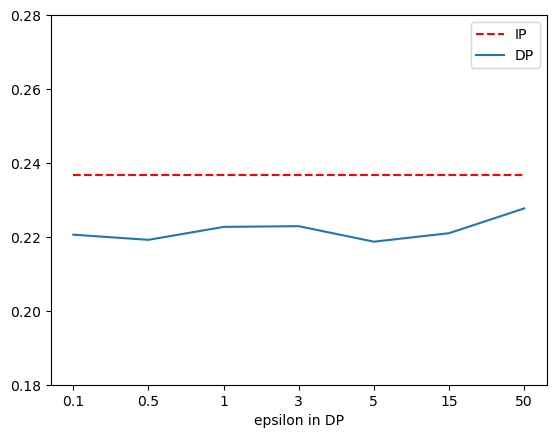

In [162]:
#here onwards plotting the acc_score for epsilon values and ip models acc_score has been calculate for say epsilon 3 ≈(noise_multiplier 0.65 in compute_sgd)
#plt.yticks([0.70, 0.75, 0.80, 0.90,0.95],["0.70","0.75","0.80","0.85","0.90"])
epsilon_list = ['0.1', '0.5', '1', '3', '5', '15', '50']

plt.ylim([0.18,0.28])

plt.xticks([0,1,2,3,4,5,6], epsilon_list)

acc_DP = [ 0.2206, 0.2192, 0.2227, 0.2229, 0.2187, 0.2210, 0.2277]
ipdd_acc=[0.2368]*len(acc_DP)
plt.plot(ipdd_acc, 'r--', label = "IP" )
plt.plot(acc_DP, label="DP")
plt.xlabel("epsilon in DP")
plt.legend()
plt.savefig("Insect_gradual DPvsOnlineIP.pdf",dpi=300, bbox_inches='tight')